In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy

import numpy as np

In [2]:
#snames = np.asarray(['AMV', 'W_S', 'S_S', 'W_M', 'S_M', 'W_N', 'S_N', 'W_S_w', 'S_S_w', 'W_M_w', 'S_M_w', 'W_N_w', 'S_N_w'])
#lnames = np.asarray(['AMV', 'Winter South', 'Summer South', 'Winter Middle', 'Summer Middle', 'Winter North', 'Summer North', 'Winter South', 'Summer South', 'Winter Middle', 'Summer Middle', 'Winter North', 'Summer North'])
#imins  = np.asarray([-75,   -40,   -60,   -80,   -60,   -60,   -60,   -50,     -60,     -80,      -60,    -60,      -45])
#imaxs  = np.asarray([0,     -10,   -10,   -30,   -20,   -20,   -20,   -10,     -20,     -30,      -25,    -20,      0])
#jmins  = np.asarray([0,     10,    20,    25,    35,    45,    50,    10,      15,      25,       30,     40,       45])
#jmaxs  = np.asarray([60,    35,    35,    50,    50,    70,    70,    25,      30,      35,       45,     60,       60])

In [3]:
datadir = '/gws/nopw/j04/acsis/jmecking/CMIP6/composites/'
figdir  = 'jet_figures/211005'

EXP          = 'piControl'
#var_ts       = 'max_lats'
var_ts       = 'max_wind'
var_field    = 'tos'
season_ts    = 'SON'
season_field = 'SON'

p_models  = ['CAS-ESM2-0_r1i1p1f1','CESM2-FV2_r1i1p1f1', 'NESM3_r1i1p1f1','EC-Earth3_r1i1p1f1',
             'FGOALS-f3-L_r1i1p1f1', 'FIO-ESM-2-0_r1i1p1f1']
# Problem with these models - need to investigate!
plot_lag = 0

if var_ts == 'max_lats':
    lmin0  = 'southernly jet (< mean)'
    lmax0  = 'northernly jet (> mean)'
    lmin1  = 'southernly jet (< mean - std)'
    lmax1  = 'northernly jet (> mean + std)'
elif var_ts == 'max_wind':
    lmin0  = 'weak jet (< mean)'
    lmax0  = 'strong jet (> mean)'
    lmin1  = 'weak jet (< mean - std)'
    lmax1  = 'strong jet (> mean + std)'
    
infile = (datadir + EXP + '_' + var_ts + '-' + season_ts + '_' + var_field +
          '-' + season_field +'_std.nc' )

if (var_ts == 'max_lats'):
    if ((season_ts == 'DJF') | (season_ts == 'MAM')):
        iminS = -40; imaxS = -10; jminS = 10; jmaxS = 35
        iminM = -80; imaxM = -30; jminM = 25; jmaxM = 50
        iminN = -60; imaxN = -20; jminN = 45; jmaxN = 70
    elif ((season_ts == 'JJA') | (season_ts == 'SON')):
        iminS = -60; imaxS = -10; jminS = 20; jmaxS = 35
        iminM = -60; imaxM = -20; jminM = 35; jmaxM = 50
        iminN = -60; imaxN = -20; jminN = 50; jmaxN = 70
if (var_ts == 'max_wind'):
    if ((season_ts == 'DJF') | (season_ts == 'MAM')):
        iminS = -50; imaxS = -10; jminS = 10; jmaxS = 25
        iminM = -80; imaxM = -30; jminM = 25; jmaxM = 35
        iminN = -60; imaxN = -20; jminN = 40; jmaxN = 60
    elif ((season_ts == 'JJA') | (season_ts == 'SON')):
        iminS = -60; imaxS = -20; jminS = 15; jmaxS = 30
        iminM = -60; imaxM = -25; jminM = 30; jmaxM = 45
        iminN = -45; imaxN = 0;   jminN = 45; jmaxN = 60
        
    
tsfileS = (datadir + '/' + EXP + '_' + var_ts + '-' + season_ts +
           '_tos_' + str(iminS) + 'to' + str(imaxS) + 'E_' +
           str(jminS) + 'to' + str(jmaxS) + 'N_std.nc')
tsfileM = (datadir + '/' + EXP + '_' + var_ts + '-' + season_ts +
           '_tos_' + str(iminM) + 'to' + str(imaxM) + 'E_' +
           str(jminM) + 'to' + str(jmaxM) + 'N_std.nc')
tsfileN = (datadir + '/' + EXP + '_' + var_ts + '-' + season_ts +
           '_tos_' + str(iminN) + 'to' + str(imaxN) + 'E_' +
           str(jminN) + 'to' + str(jmaxN) + 'N_std.nc')

# Running mean for composite of timeseries:
rm = 3

# Colors for plots:
cmap  = plt.get_cmap('seismic',21)
vmin  = -1*1.05
vmax  =  1*1.05
colN  = 'C1'
colM  = 'C2'
colS  = 'C4'

In [4]:
# Read in 2D data:

# Read in information:
ncid   = Dataset(infile,'r')
lon    = ncid.variables['lon'][:]
lat    = ncid.variables['lat'][:]
lags   = ncid.variables['lags'][:]
models = ncid.variables['models'][:]
ncid.close()

nm = len(models)
print(nm)
nl = np.size(lags)

ll = np.squeeze(np.where(lags == plot_lag))

# Loop through each season combination and compute data:
mean_MMM  = np.zeros((np.size(lat),np.size(lon)),'float')
min0_MMM  = np.zeros((np.size(lat),np.size(lon)),'float')
max0_MMM  = np.zeros((np.size(lat),np.size(lon)),'float')
min1_MMM  = np.zeros((np.size(lat),np.size(lon)),'float')
max1_MMM  = np.zeros((np.size(lat),np.size(lon)),'float')
data_mean = np.zeros((nm-len(p_models),np.size(lat),np.size(lon)),'float')
data_min0 = np.zeros((nm-len(p_models),np.size(lat),np.size(lon)),'float')
data_max0 = np.zeros((nm-len(p_models),np.size(lat),np.size(lon)),'float')
data_min1 = np.zeros((nm-len(p_models),np.size(lat),np.size(lon)),'float')
data_max1 = np.zeros((nm-len(p_models),np.size(lat),np.size(lon)),'float')

cc = 0
for mm in range(0,nm):
    print(models[mm])
    model = models[mm].split('_')[0]
    ENS   = models[mm].split('_')[1]

    ncid      = Dataset(infile,'r')
    data_mean_tmp = ncid.variables['mean'][mm,:,:]
    data_min0_tmp = ncid.variables['min_std0'][mm,ll,:,:]
    data_max0_tmp = ncid.variables['max_std0'][mm,ll,:,:]
    data_min1_tmp = ncid.variables['min_std1'][mm,ll,:,:]
    data_max1_tmp = ncid.variables['max_std1'][mm,ll,:,:]
    ncid.close()

    if models[mm] not in p_models:
        mean_MMM[:,:] = mean_MMM[:,:] + data_mean_tmp
        min0_MMM[:,:] = min0_MMM[:,:] + data_min0_tmp
        max0_MMM[:,:] = max0_MMM[:,:] + data_max0_tmp
        min1_MMM[:,:] = min1_MMM[:,:] + data_min1_tmp
        max1_MMM[:,:] = max1_MMM[:,:] + data_max1_tmp
        data_mean[cc,:,:] = data_mean_tmp
        data_min0[cc,:,:] = data_min0_tmp
        data_max0[cc,:,:] = data_max0_tmp
        data_min1[cc,:,:] = data_min1_tmp
        data_max1[cc,:,:] = data_max1_tmp
        cc = cc + 1
        

mean_MMM[:,:] = mean_MMM[:,:]/cc
min0_MMM[:,:] = min0_MMM[:,:]/cc
max0_MMM[:,:] = max0_MMM[:,:]/cc 
min1_MMM[:,:] = min1_MMM[:,:]/cc
max1_MMM[:,:] = max1_MMM[:,:]/cc 

39
ACCESS-CM2_r1i1p1f1
ACCESS-ESM1-5_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
BCC-ESM1_r1i1p1f1
CAMS-CSM1-0_r1i1p1f1
CAS-ESM2-0_r1i1p1f1
CESM2_r1i1p1f1
CESM2-FV2_r1i1p1f1
CESM2-WACCM_r1i1p1f1
CESM2-WACCM-FV2_r1i1p1f1
CIESM_r1i1p1f1
CMCC-CM2-SR5_r1i1p1f1
CNRM-CM6-1_r1i1p1f2
CNRM-CM6-1-HR_r1i1p1f2
CNRM-ESM2-1_r1i1p1f2
CanESM5_r1i1p1f1
CanESM5_r1i1p2f1
EC-Earth3_r1i1p1f1
EC-Earth3-AerChem_r1i1p1f1
EC-Earth3-Veg_r1i1p1f1
EC-Earth3-Veg-LR_r1i1p1f1
FGOALS-f3-L_r1i1p1f1
FGOALS-g3_r1i1p1f1
FIO-ESM-2-0_r1i1p1f1
GFDL-CM4_r1i1p1f1
HadGEM3-GC31-LL_r1i1p1f1
HadGEM3-GC31-MM_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
IPSL-CM6A-LR_r1i2p1f1
MCM-UA-1-0_r1i1p1f1
MIROC-ES2L_r1i1p1f2
MIROC6_r1i1p1f1
MPI-ESM-1-2-HAM_r1i1p1f1
MPI-ESM1-2-HR_r1i1p1f1
MPI-ESM1-2-LR_r1i1p1f1
MRI-ESM2-0_r1i1p1f1
NESM3_r1i1p1f1
NorESM2-MM_r1i1p1f1
UKESM1-0-LL_r1i1p1f2


In [5]:
# Read in Timeseries data:

ncid   = Dataset(tsfileN,'r')
lags   = ncid.variables['lags'][:]
models = ncid.variables['models'][:]
dataN_mean = ncid.variables['mean'][:,:]
dataN_min0 = ncid.variables['min_std0'][:,:,:]
dataN_max0 = ncid.variables['max_std0'][:,:,:]
dataN_min1 = ncid.variables['min_std1'][:,:,:]
dataN_max1 = ncid.variables['max_std1'][:,:,:]
ncid.close()
nm = len(models)
print(nm)

# Remove problem models:
for pp in p_models:
    ii = np.where(models == pp)
    models    = np.delete(models,ii,axis=0)
    dataN_mean = np.delete(dataN_mean,ii,axis=0)
    dataN_min0 = np.delete(dataN_min0,ii,axis=0)
    dataN_max0 = np.delete(dataN_max0,ii,axis=0)
    dataN_min1 = np.delete(dataN_min1,ii,axis=0)
    dataN_max1 = np.delete(dataN_max1,ii,axis=0)
    

nm = len(models)
print(nm)
nl = np.size(lags)

# Reshape and redefine lags to be months since middle of season:
lags = lags*12
lags = np.tile(lags,(12,1)).T
for mm in range(0,12):
    lags[:,mm] = lags[:,mm] + mm
lags = np.ndarray.flatten(lags)
if season_ts == 'DJF':
    lags = lags + 0
if season_ts == 'MAM':
    lags = lags - 3
if season_ts == 'JJA':
    lags = lags - 6
if season_ts == 'SON':
    lags = lags - 9

dataN_min0 = np.reshape(dataN_min0,(len(models),nl*12))
dataN_max0 = np.reshape(dataN_max0,(len(models),nl*12))
dataN_min1 = np.reshape(dataN_min1,(len(models),nl*12))
dataN_max1 = np.reshape(dataN_max1,(len(models),nl*12))

# Smooth data with running mean:
rm = 3
dataN_min0_f = np.zeros((nm,nl*12-rm+1),'float')
dataN_max0_f = np.zeros((nm,nl*12-rm+1),'float')
dataN_min1_f = np.zeros((nm,nl*12-rm+1),'float')
dataN_max1_f = np.zeros((nm,nl*12-rm+1),'float')

lags_f      = np.convolve(lags,     1/rm*np.ones(3,'float'),mode='valid')
for mm in range(0,nm):
    dataN_min0_f[mm,:] = np.convolve(dataN_min0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataN_max0_f[mm,:] = np.convolve(dataN_max0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataN_min1_f[mm,:] = np.convolve(dataN_min1[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataN_max1_f[mm,:] = np.convolve(dataN_max1[mm,:],1/rm*np.ones(3,'float'),mode='valid')

38
33


In [6]:
# Read in Timeseries data:

ncid   = Dataset(tsfileM,'r')
lags   = ncid.variables['lags'][:]
models = ncid.variables['models'][:]
dataM_mean = ncid.variables['mean'][:,:]
dataM_min0 = ncid.variables['min_std0'][:,:,:]
dataM_max0 = ncid.variables['max_std0'][:,:,:]
dataM_min1 = ncid.variables['min_std1'][:,:,:]
dataM_max1 = ncid.variables['max_std1'][:,:,:]
ncid.close()

# Remove problem models:
for pp in p_models:
    ii = np.where(models == pp)
    models    = np.delete(models,ii,axis=0)
    dataM_mean = np.delete(dataM_mean,ii,axis=0)
    dataM_min0 = np.delete(dataM_min0,ii,axis=0)
    dataM_max0 = np.delete(dataM_max0,ii,axis=0)
    dataM_min1 = np.delete(dataM_min1,ii,axis=0)
    dataM_max1 = np.delete(dataM_max1,ii,axis=0)
    

nm = len(models)
nl = np.size(lags)

# Reshape and redefine lags to be months since middle of season:
lags = lags*12
lags = np.tile(lags,(12,1)).T
for mm in range(0,12):
    lags[:,mm] = lags[:,mm] + mm
lags = np.ndarray.flatten(lags)
if season_ts == 'DJF':
    lags = lags + 0
if season_ts == 'MAM':
    lags = lags - 3
if season_ts == 'JJA':
    lags = lags - 6
if season_ts == 'SON':
    lags = lags - 9

dataM_min0 = np.reshape(dataM_min0,(len(models),nl*12))
dataM_max0 = np.reshape(dataM_max0,(len(models),nl*12))
dataM_min1 = np.reshape(dataM_min1,(len(models),nl*12))
dataM_max1 = np.reshape(dataM_max1,(len(models),nl*12))

# Smooth data with running mean:
rm = 3
dataM_min0_f = np.zeros((nm,nl*12-rm+1),'float')
dataM_max0_f = np.zeros((nm,nl*12-rm+1),'float')
dataM_min1_f = np.zeros((nm,nl*12-rm+1),'float')
dataM_max1_f = np.zeros((nm,nl*12-rm+1),'float')

lags_f      = np.convolve(lags,     1/rm*np.ones(3,'float'),mode='valid')
for mm in range(0,nm):
    dataM_min0_f[mm,:] = np.convolve(dataM_min0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataM_max0_f[mm,:] = np.convolve(dataM_max0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataM_min1_f[mm,:] = np.convolve(dataM_min1[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataM_max1_f[mm,:] = np.convolve(dataM_max1[mm,:],1/rm*np.ones(3,'float'),mode='valid')

In [7]:
# Read in Timeseries data:

ncid   = Dataset(tsfileS,'r')
lags   = ncid.variables['lags'][:]
models = ncid.variables['models'][:]
dataS_mean = ncid.variables['mean'][:,:]
dataS_min0 = ncid.variables['min_std0'][:,:,:]
dataS_max0 = ncid.variables['max_std0'][:,:,:]
dataS_min1 = ncid.variables['min_std1'][:,:,:]
dataS_max1 = ncid.variables['max_std1'][:,:,:]
ncid.close()

# Remove problem models:
for pp in p_models:
    ii = np.where(models == pp)
    models    = np.delete(models,ii,axis=0)
    dataS_mean = np.delete(dataS_mean,ii,axis=0)
    dataS_min0 = np.delete(dataS_min0,ii,axis=0)
    dataS_max0 = np.delete(dataS_max0,ii,axis=0)
    dataS_min1 = np.delete(dataS_min1,ii,axis=0)
    dataS_max1 = np.delete(dataS_max1,ii,axis=0)
    

nm = len(models)
nl = np.size(lags)

# Reshape and redefine lags to be months since middle of season:
lags = lags*12
lags = np.tile(lags,(12,1)).T
for mm in range(0,12):
    lags[:,mm] = lags[:,mm] + mm
lags = np.ndarray.flatten(lags)
if season_ts == 'DJF':
    lags = lags + 0
if season_ts == 'MAM':
    lags = lags - 3
if season_ts == 'JJA':
    lags = lags - 6
if season_ts == 'SON':
    lags = lags - 9

dataS_min0 = np.reshape(dataS_min0,(len(models),nl*12))
dataS_max0 = np.reshape(dataS_max0,(len(models),nl*12))
dataS_min1 = np.reshape(dataS_min1,(len(models),nl*12))
dataS_max1 = np.reshape(dataS_max1,(len(models),nl*12))

# Smooth data with running mean:
rm = 3
dataS_min0_f = np.zeros((nm,nl*12-rm+1),'float')
dataS_max0_f = np.zeros((nm,nl*12-rm+1),'float')
dataS_min1_f = np.zeros((nm,nl*12-rm+1),'float')
dataS_max1_f = np.zeros((nm,nl*12-rm+1),'float')

lags_f      = np.convolve(lags,     1/rm*np.ones(3,'float'),mode='valid')
for mm in range(0,nm):
    dataS_min0_f[mm,:] = np.convolve(dataS_min0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataS_max0_f[mm,:] = np.convolve(dataS_max0[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataS_min1_f[mm,:] = np.convolve(dataS_min1[mm,:],1/rm*np.ones(3,'float'),mode='valid')
    dataS_max1_f[mm,:] = np.convolve(dataS_max1[mm,:],1/rm*np.ones(3,'float'),mode='valid')

/home/users/jmecking001/miniconda3/envs/working/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/jmecking001/miniconda3/envs/working/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/users/jmecking001/miniconda3/envs/working/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matp

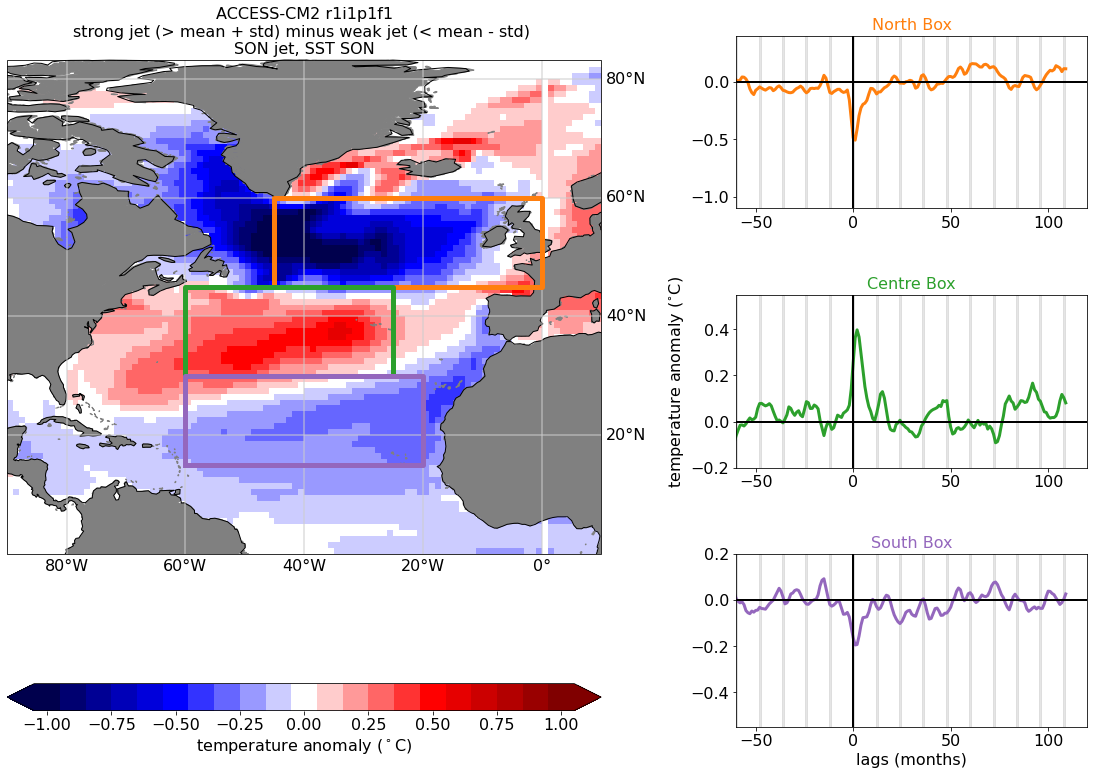

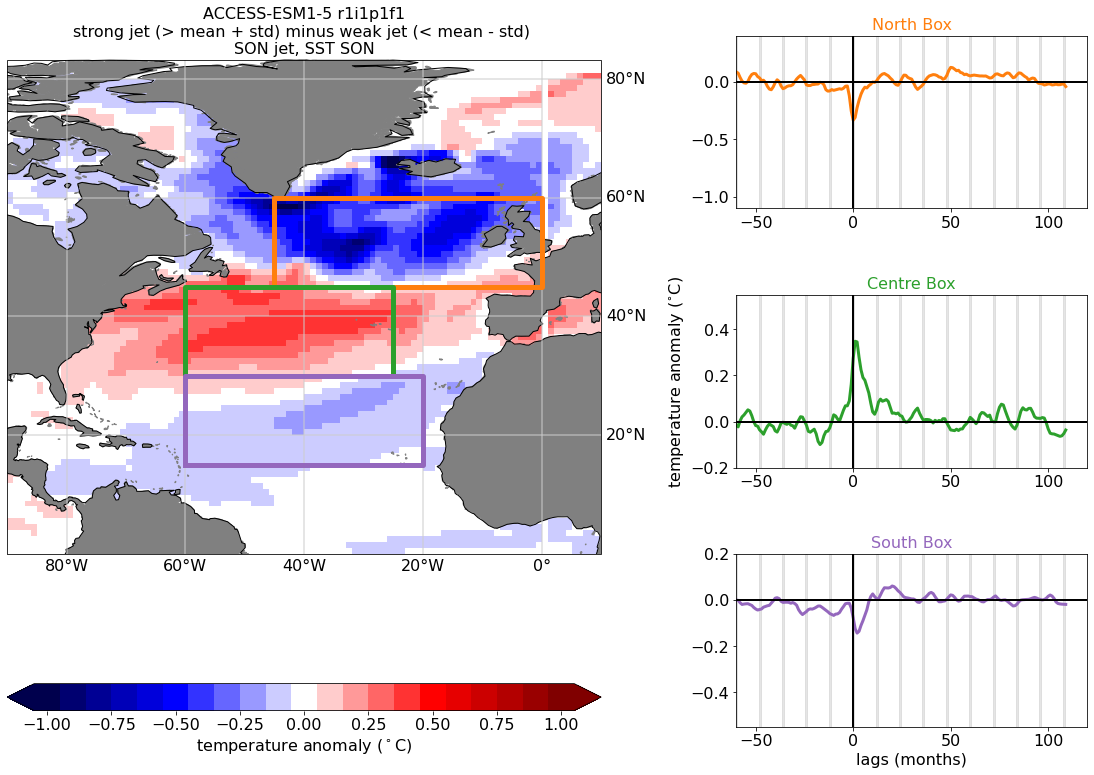

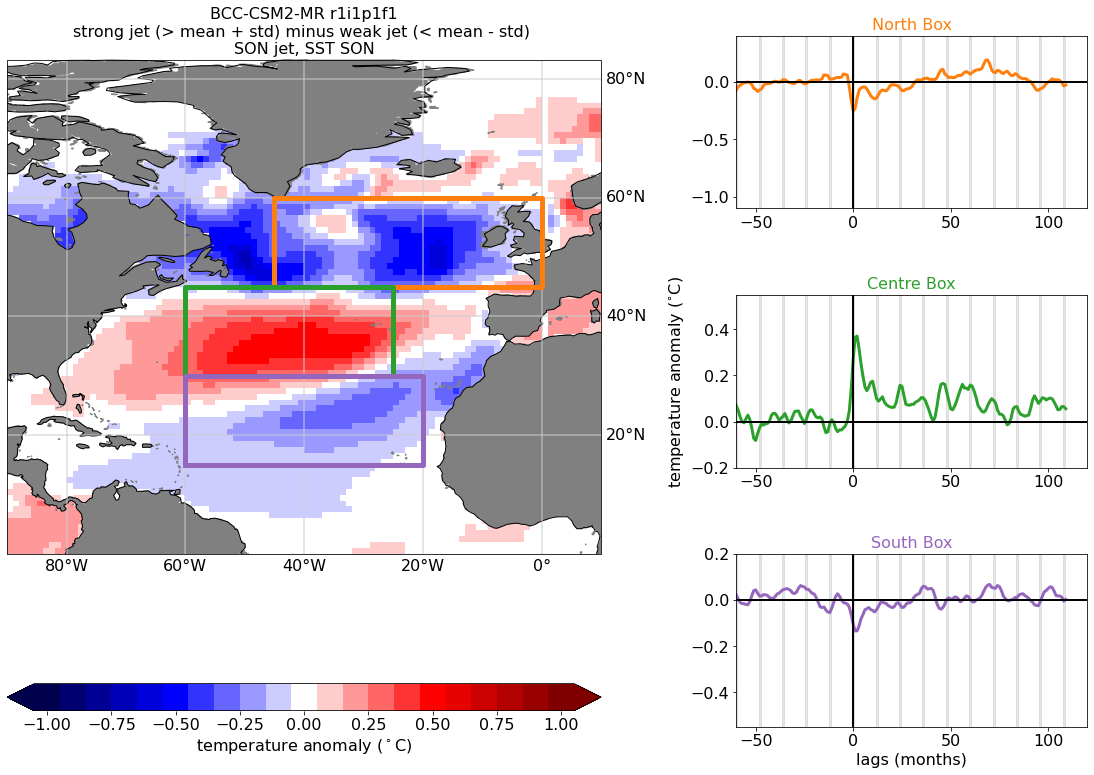

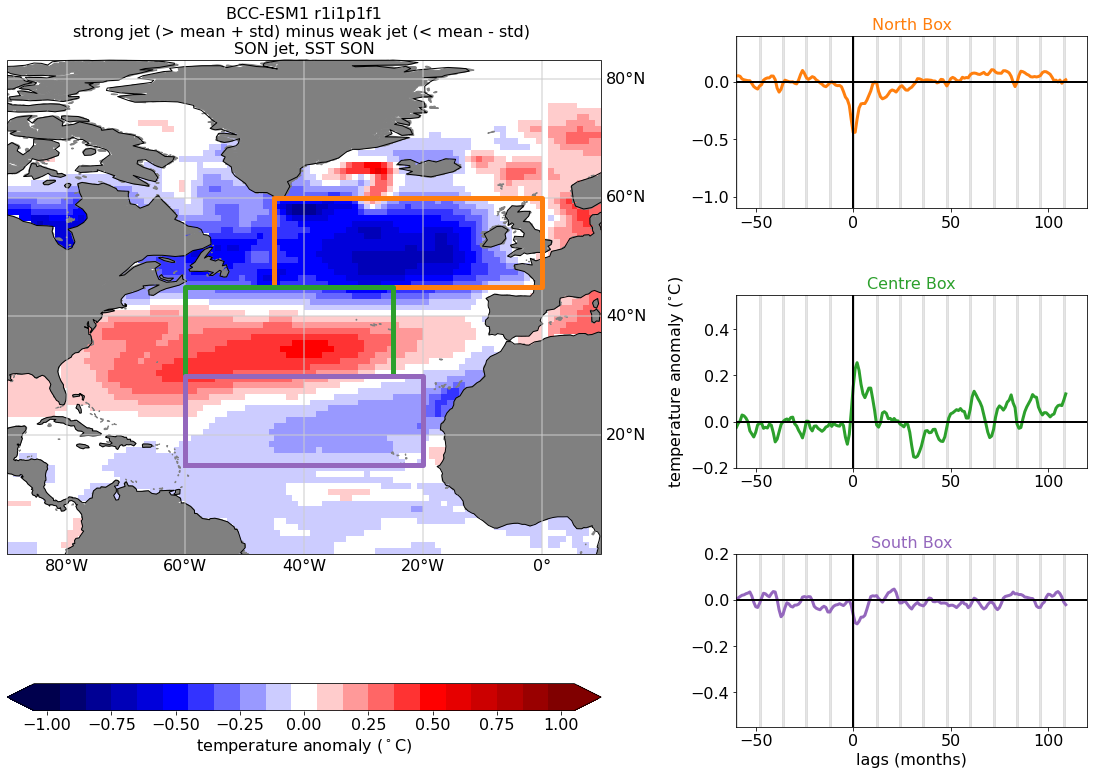

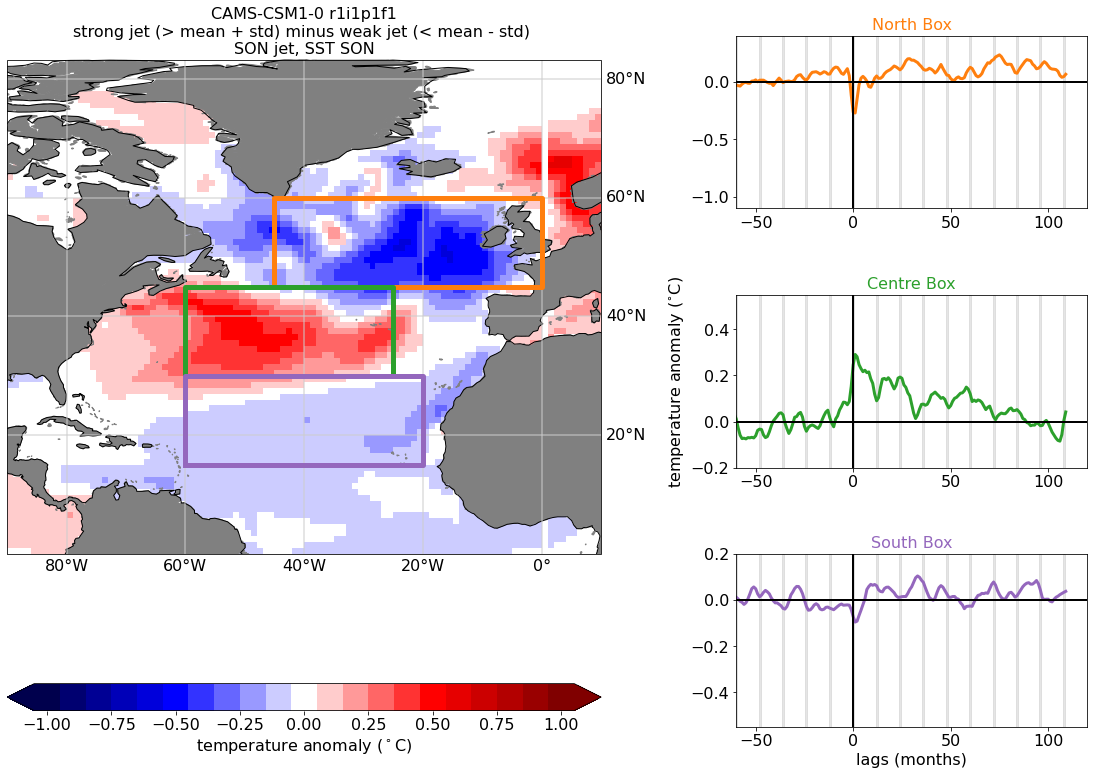

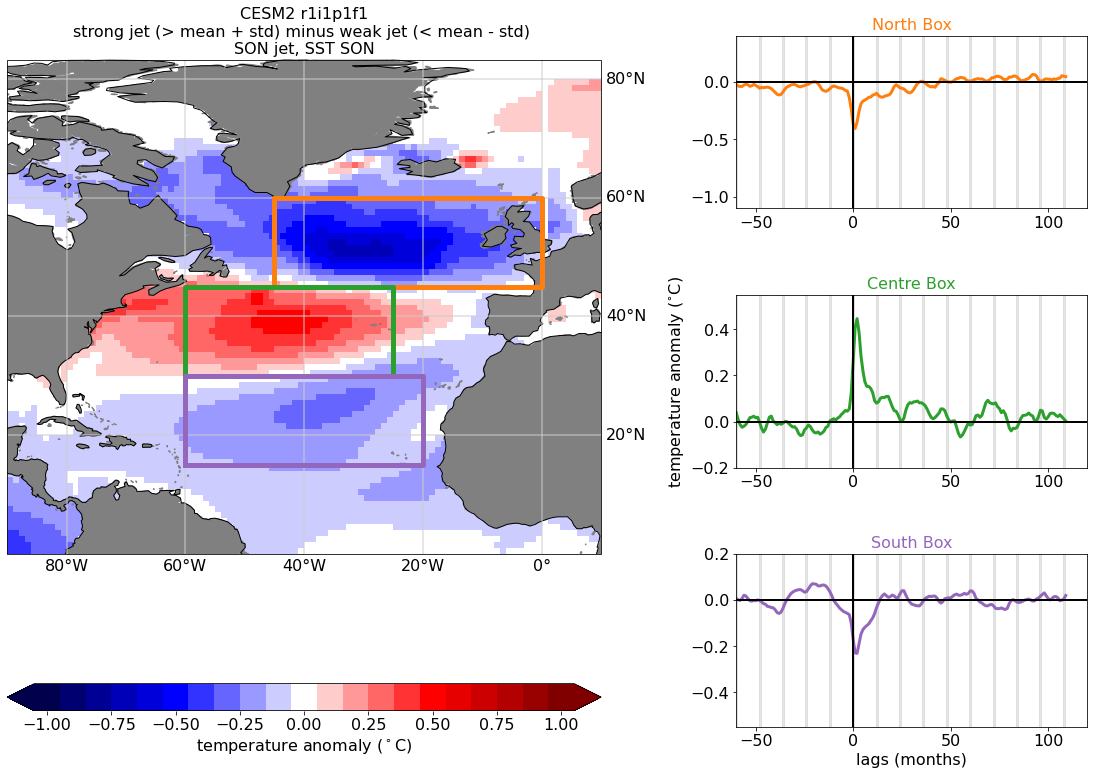

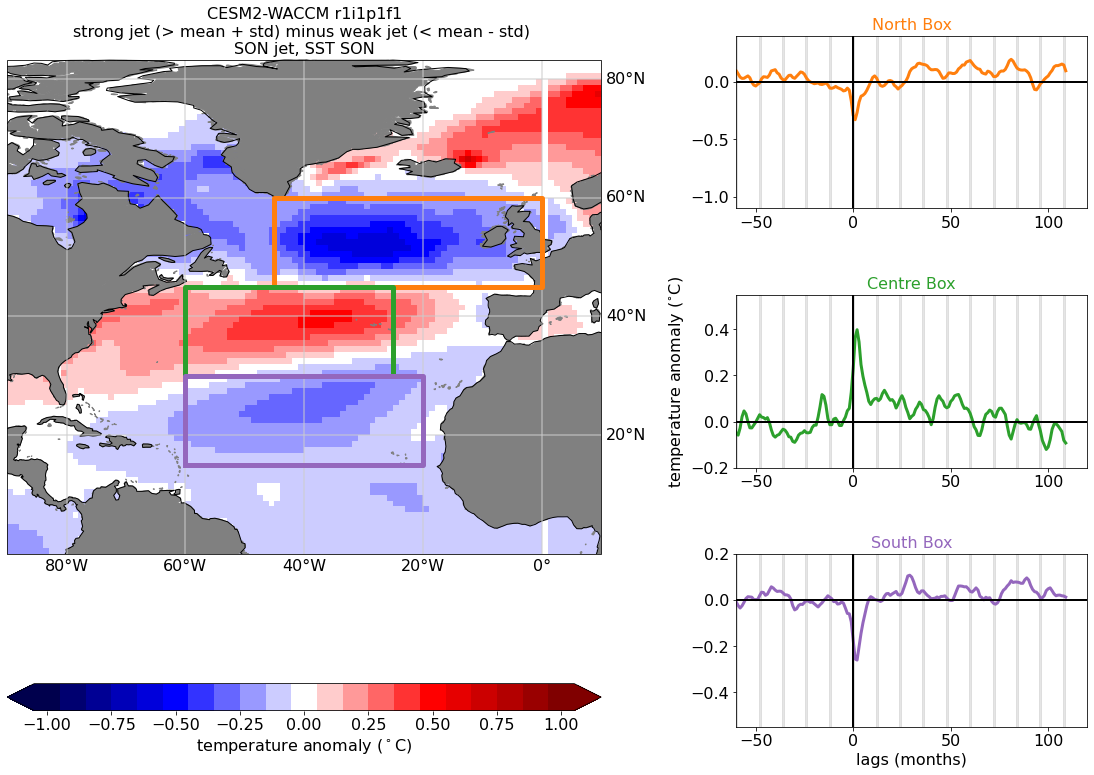

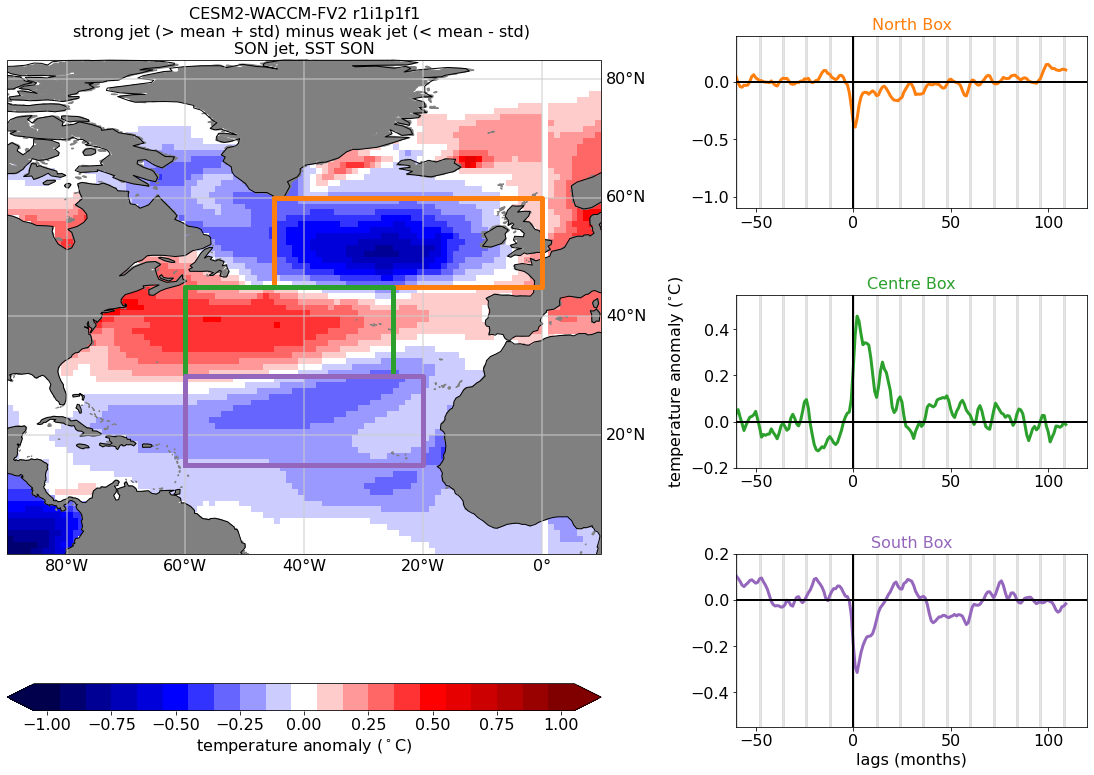

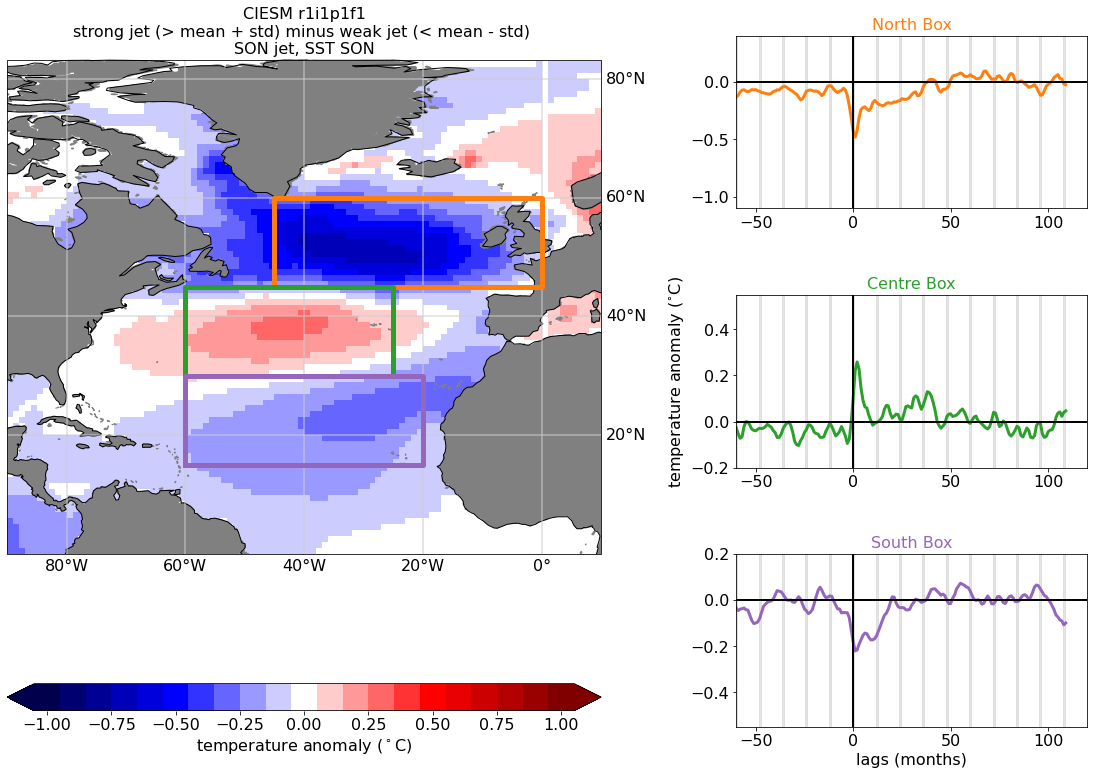

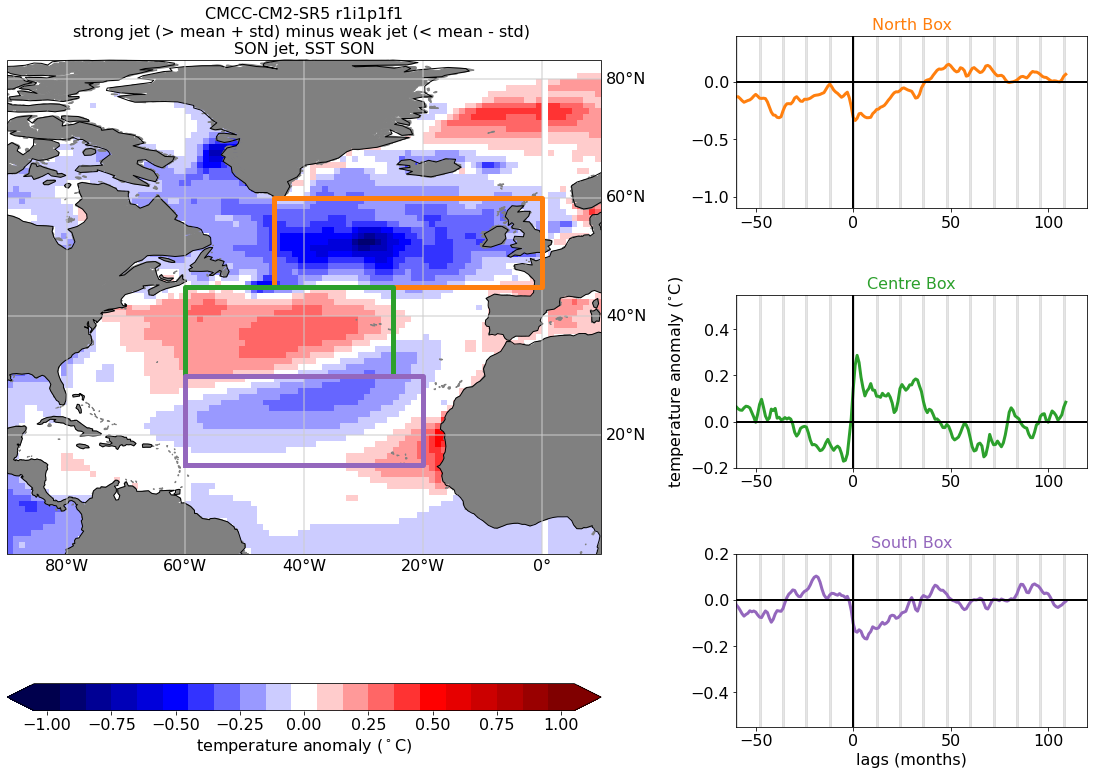

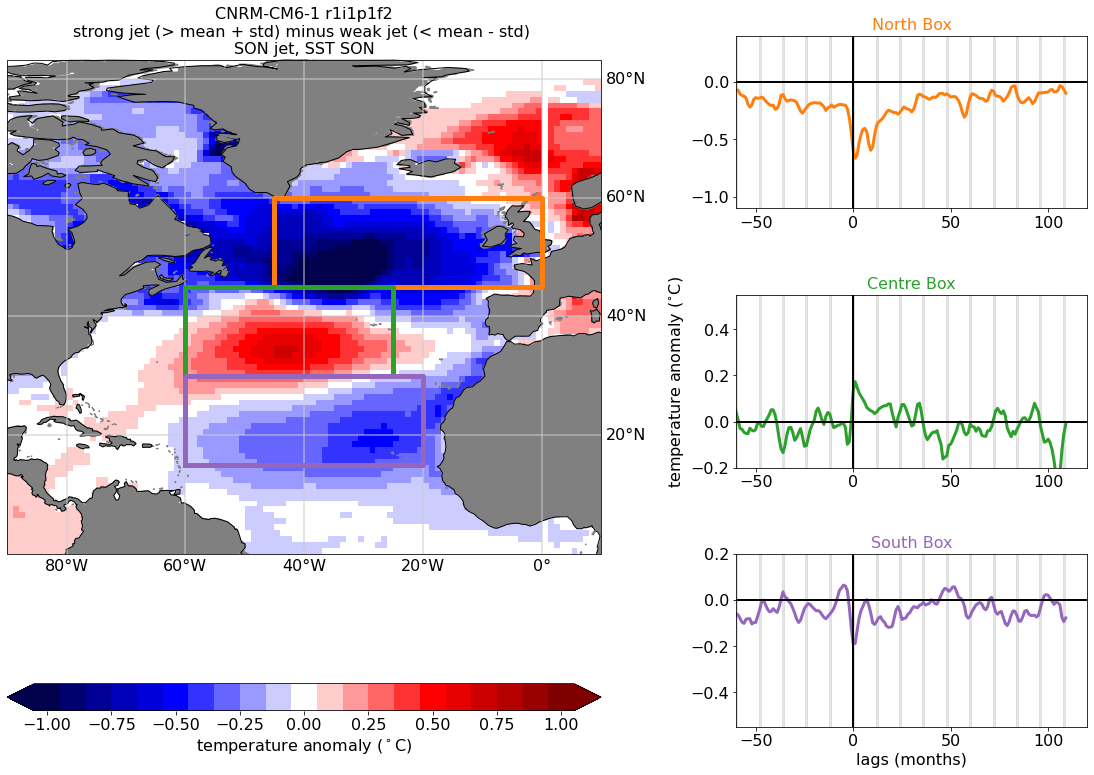

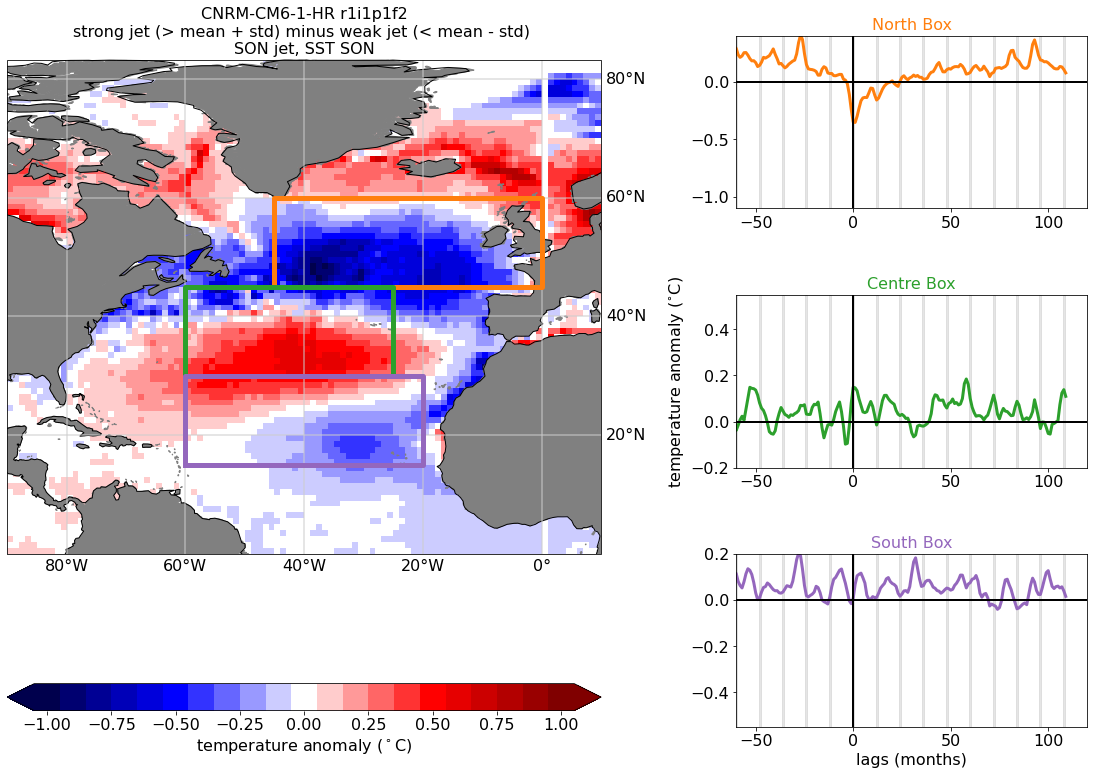

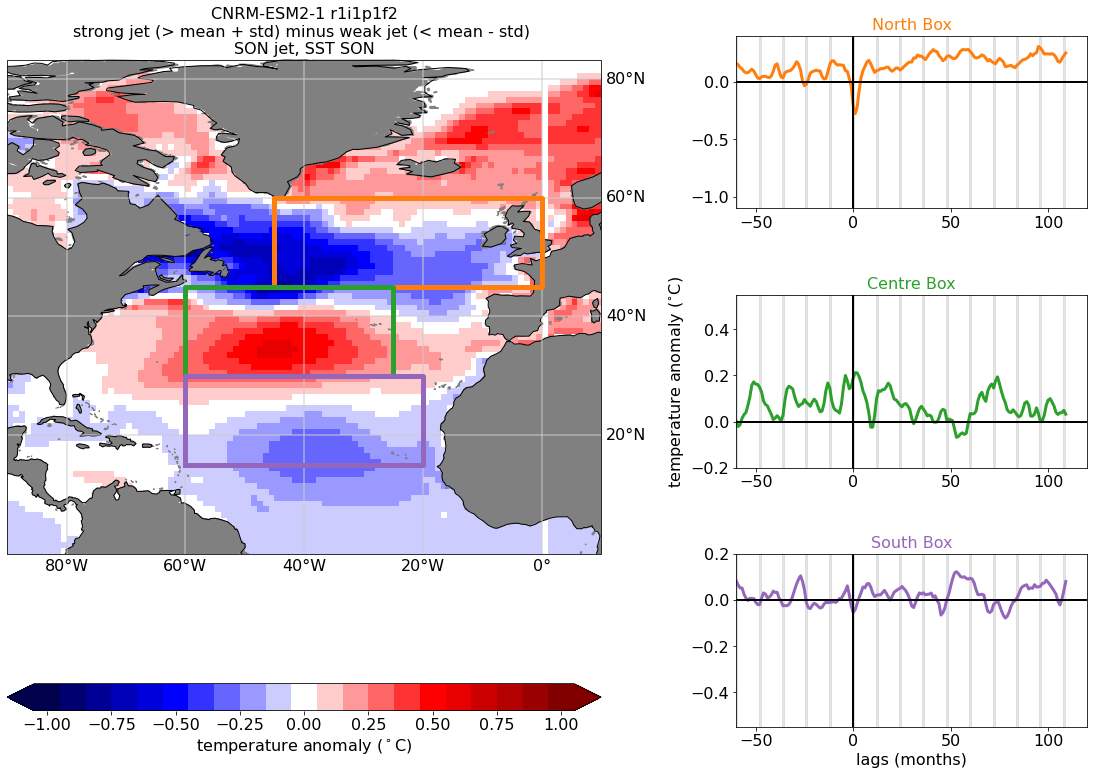

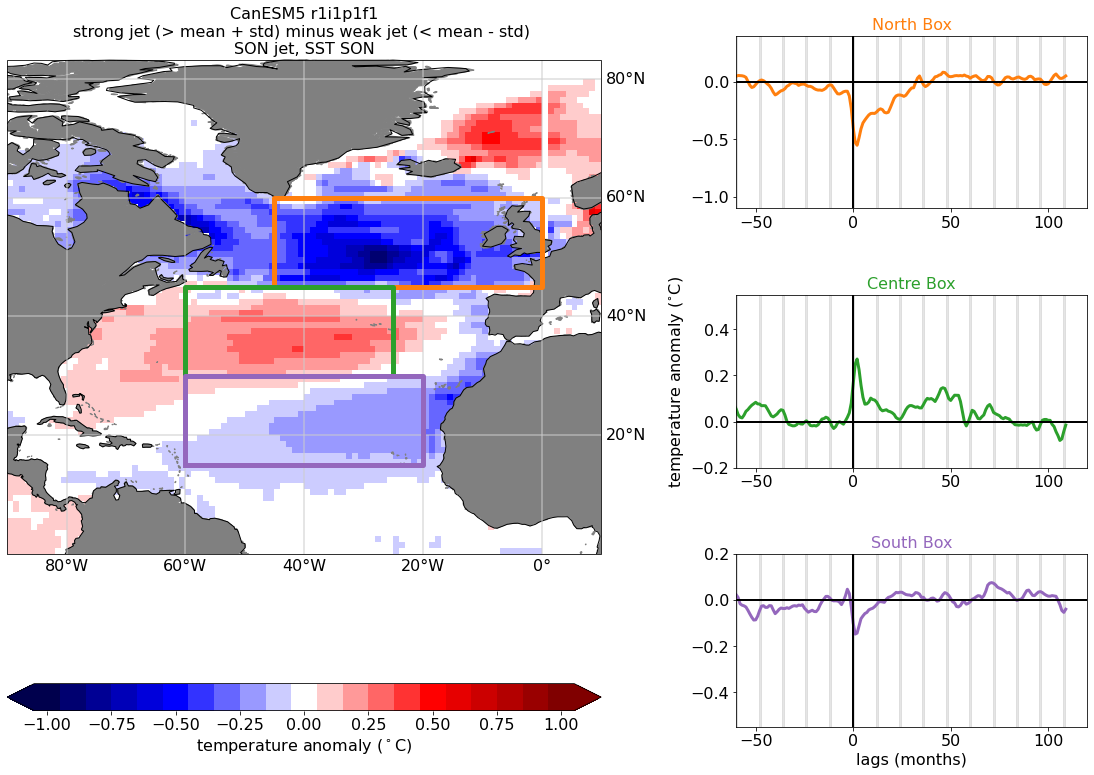

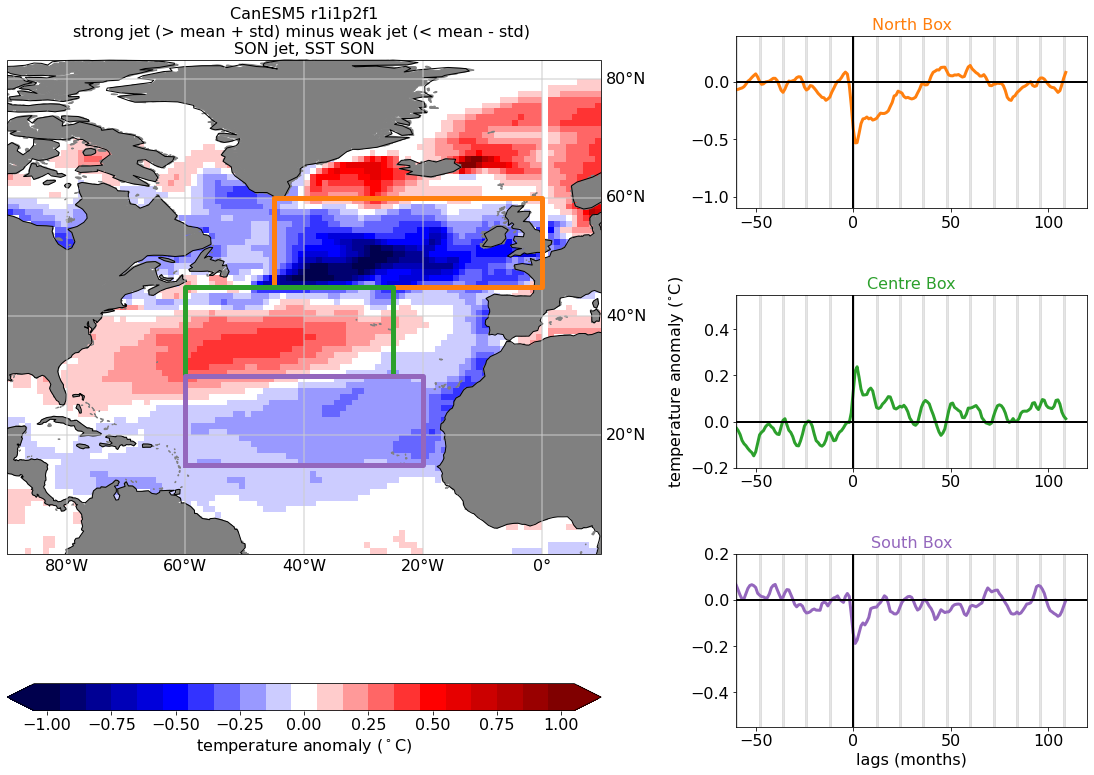

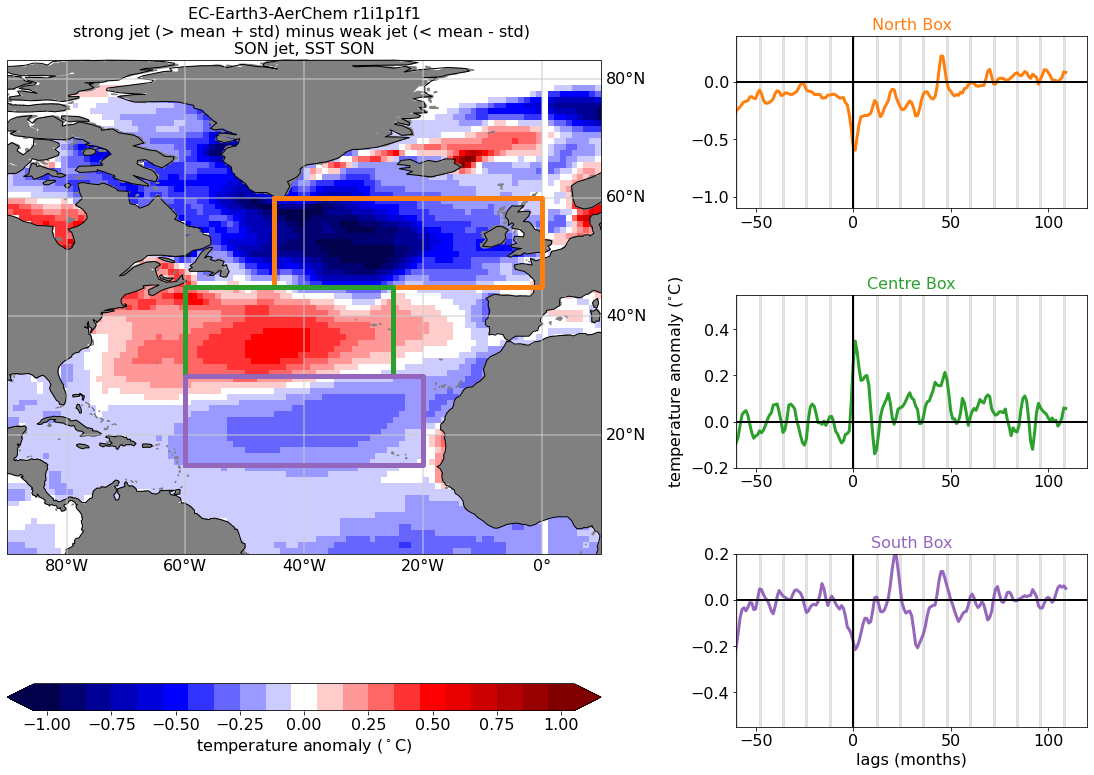

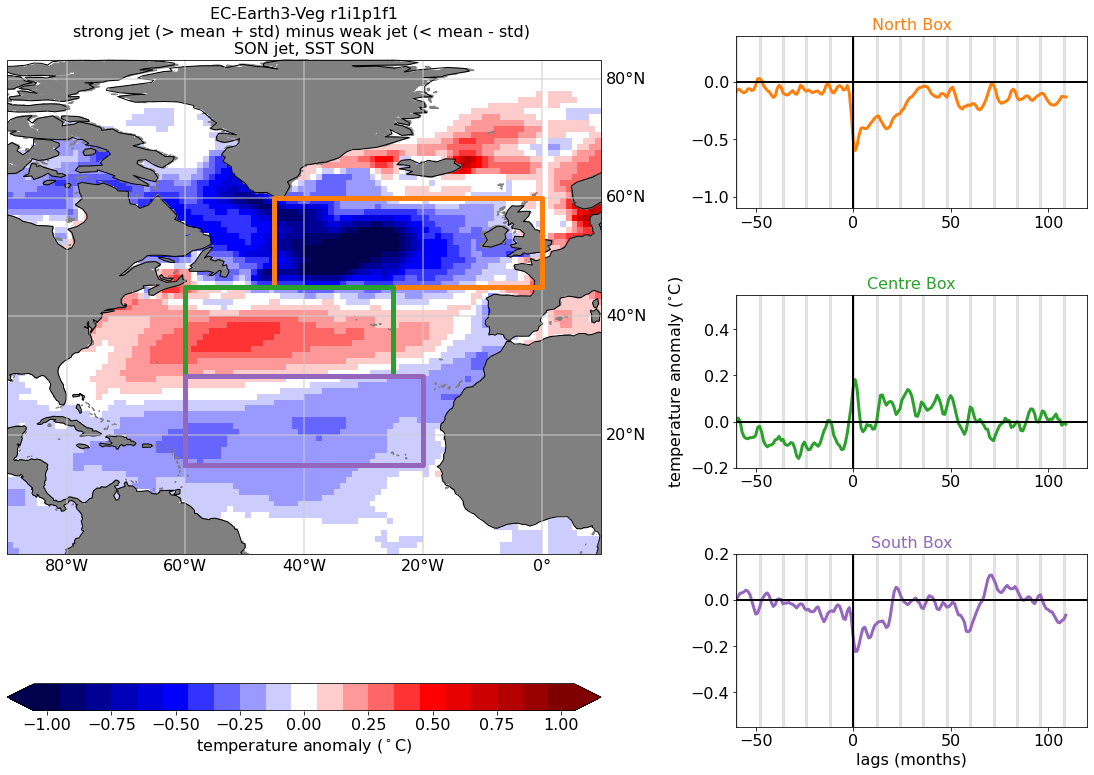

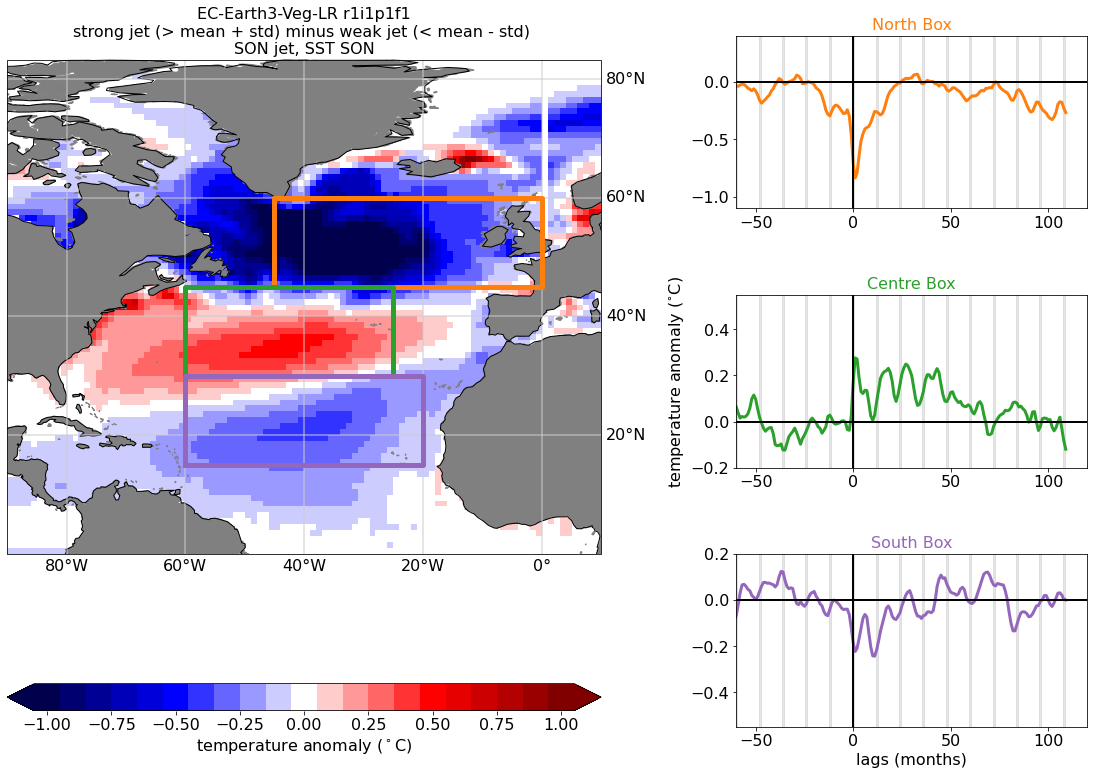

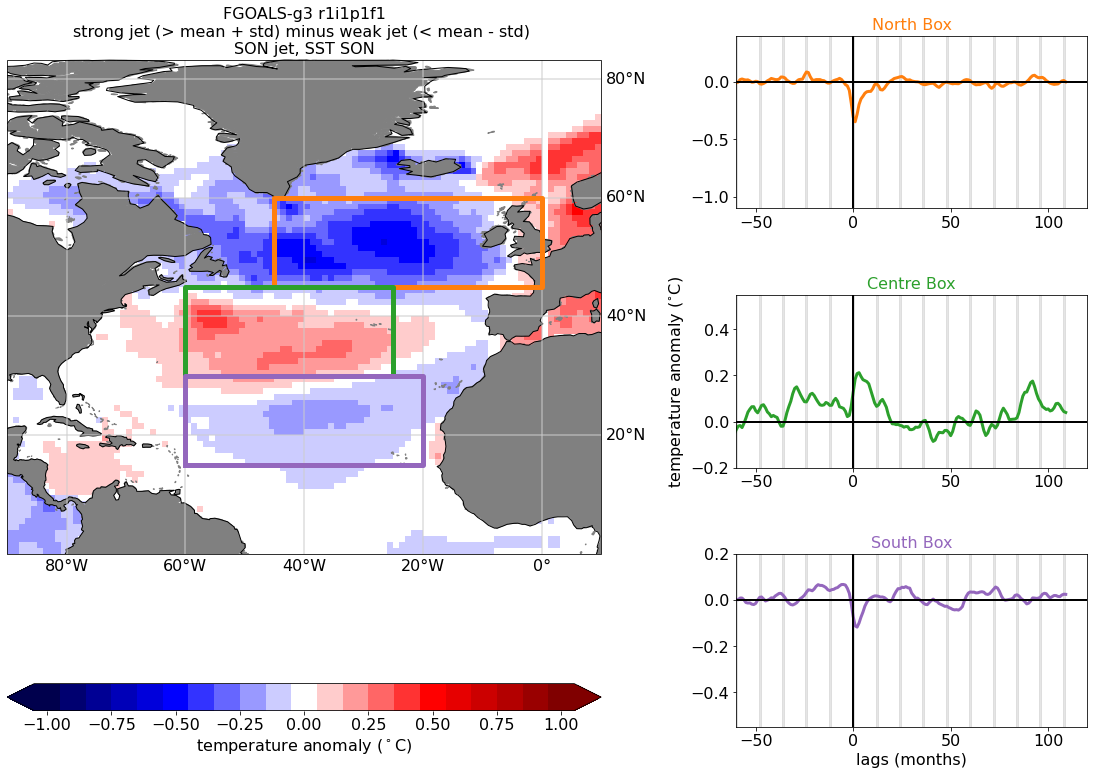

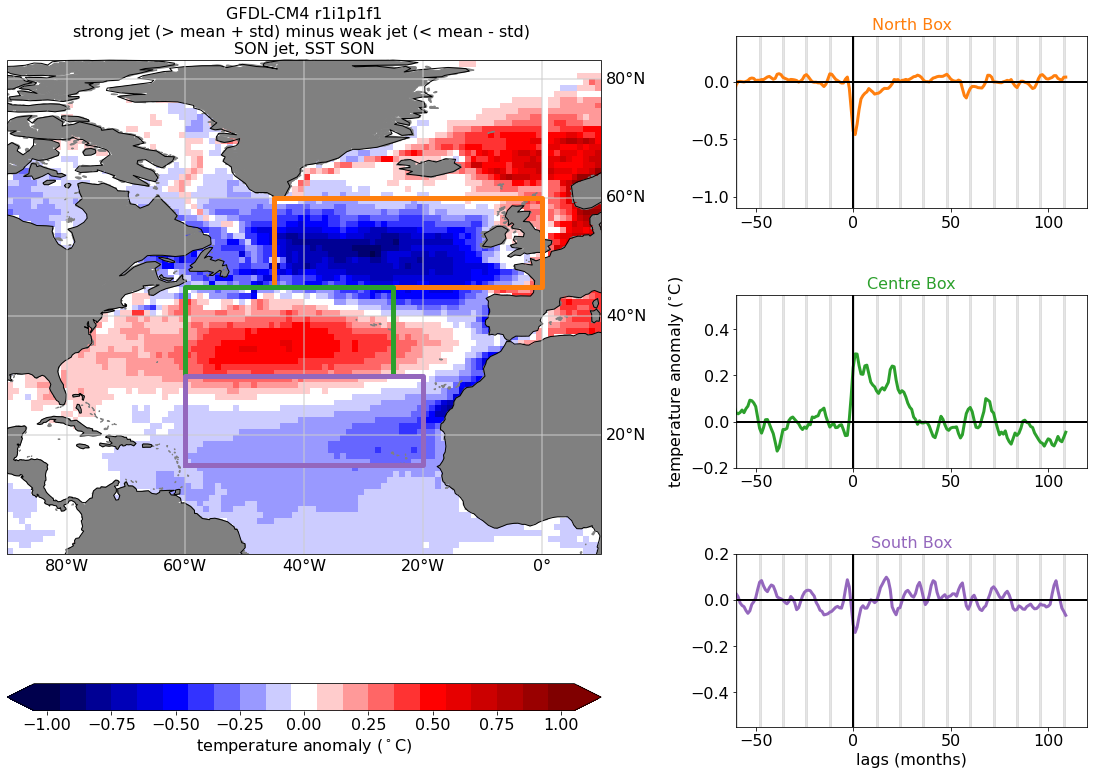

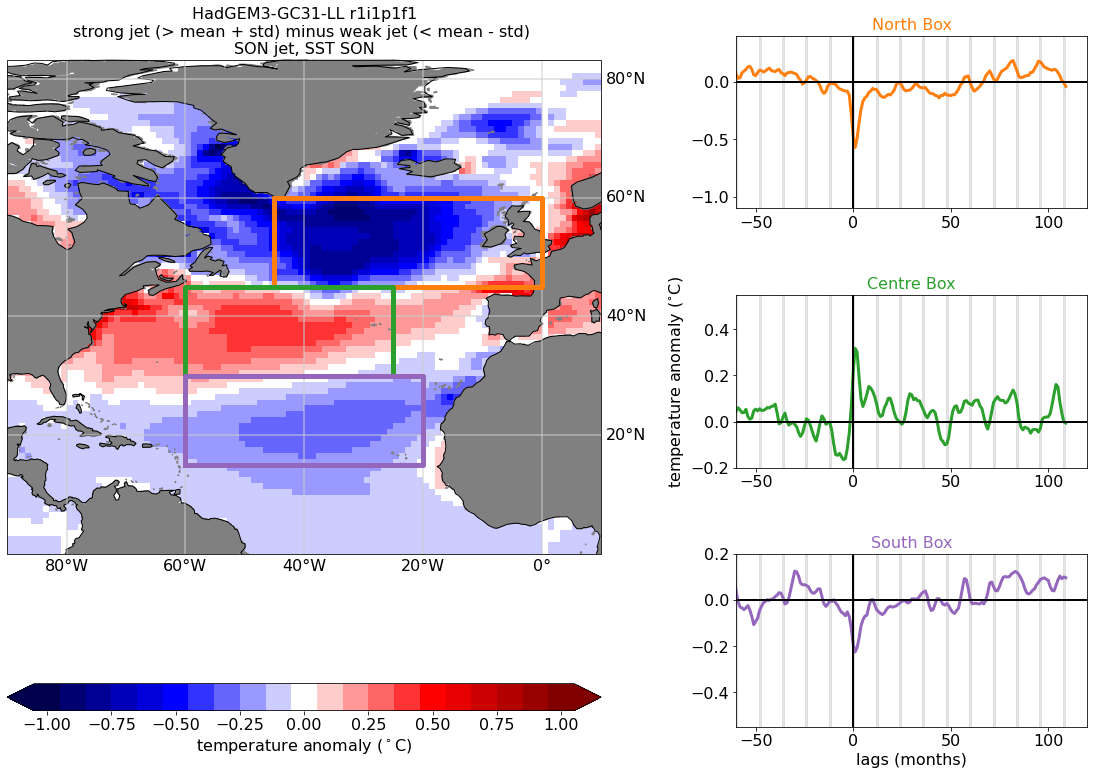

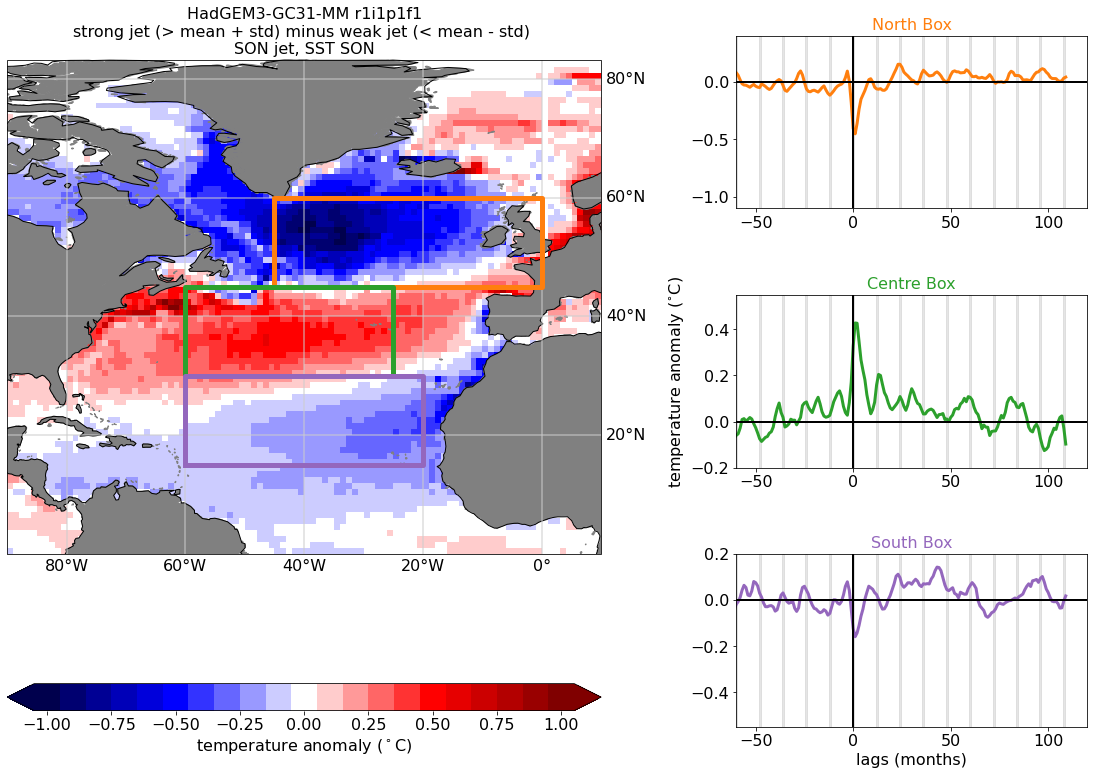

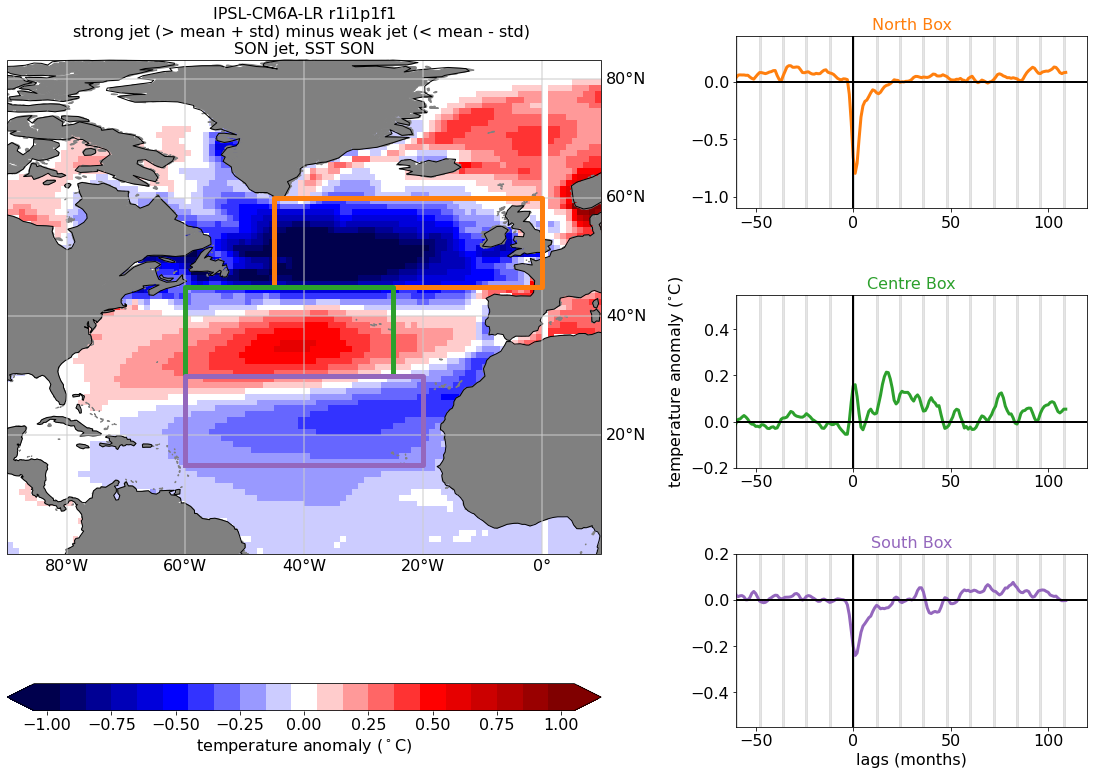

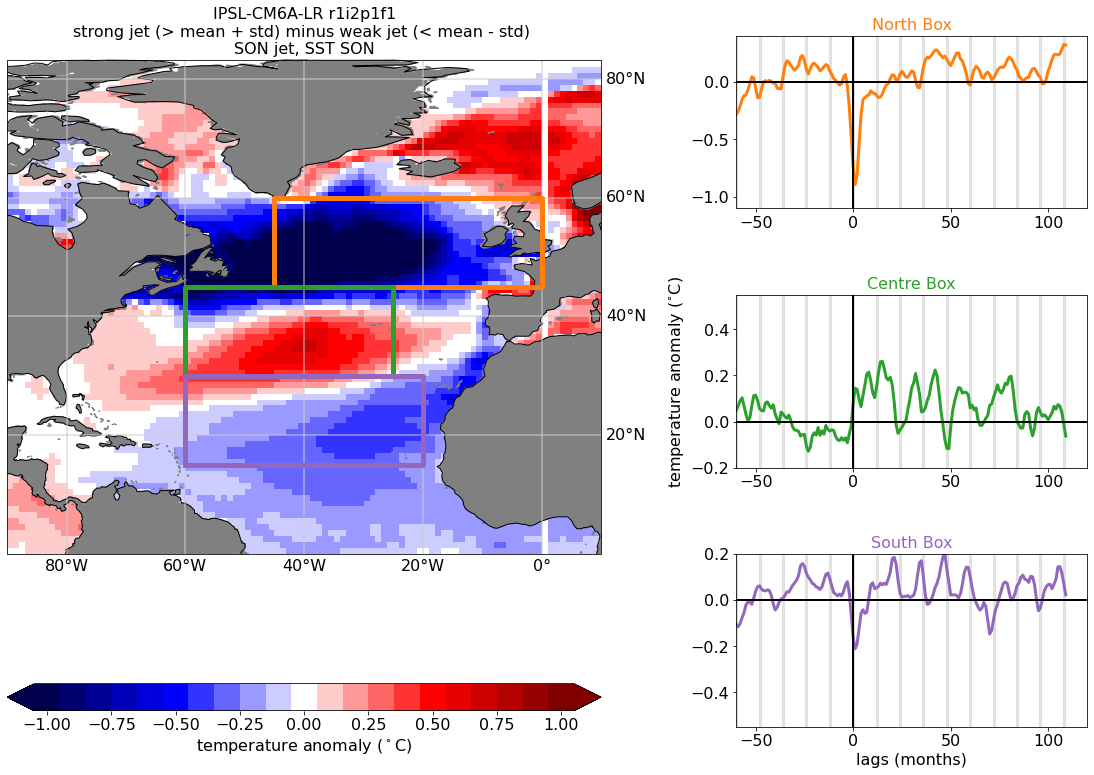

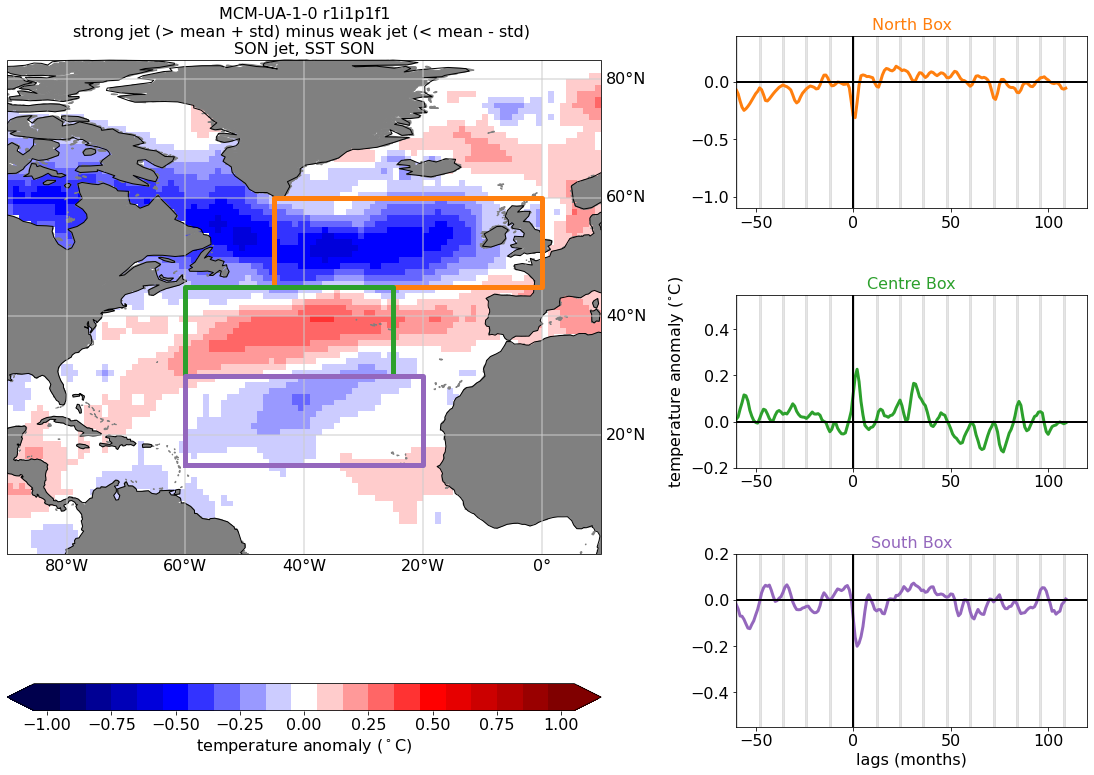

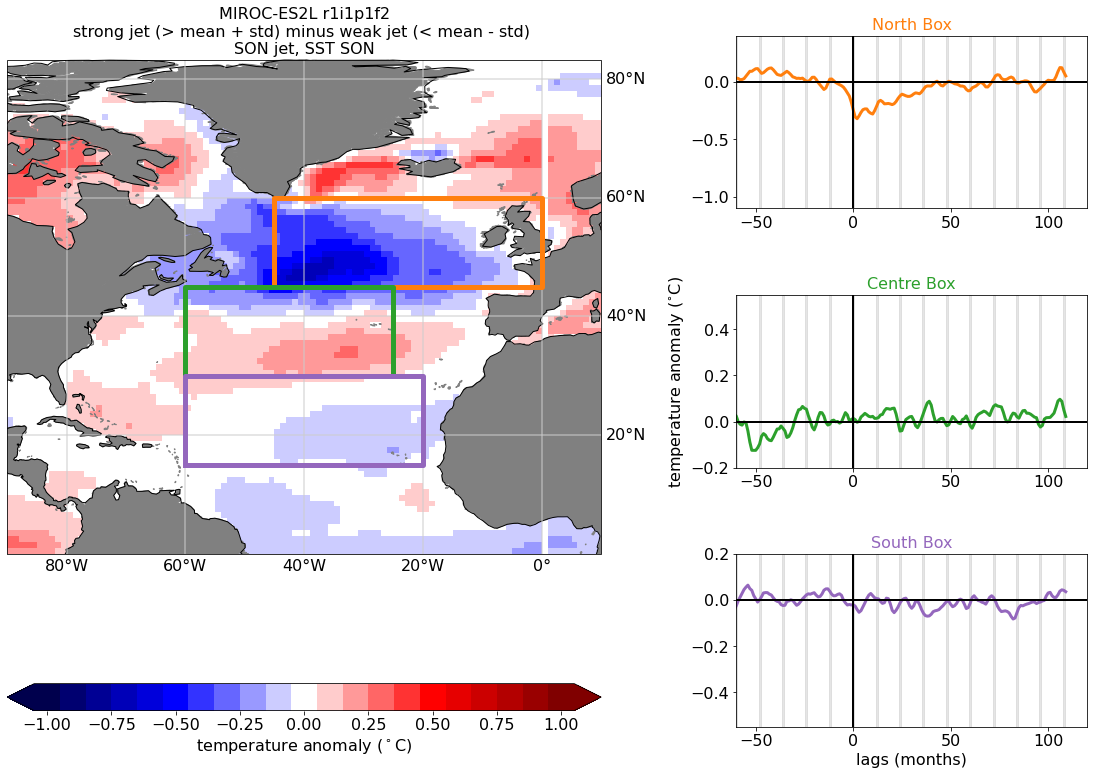

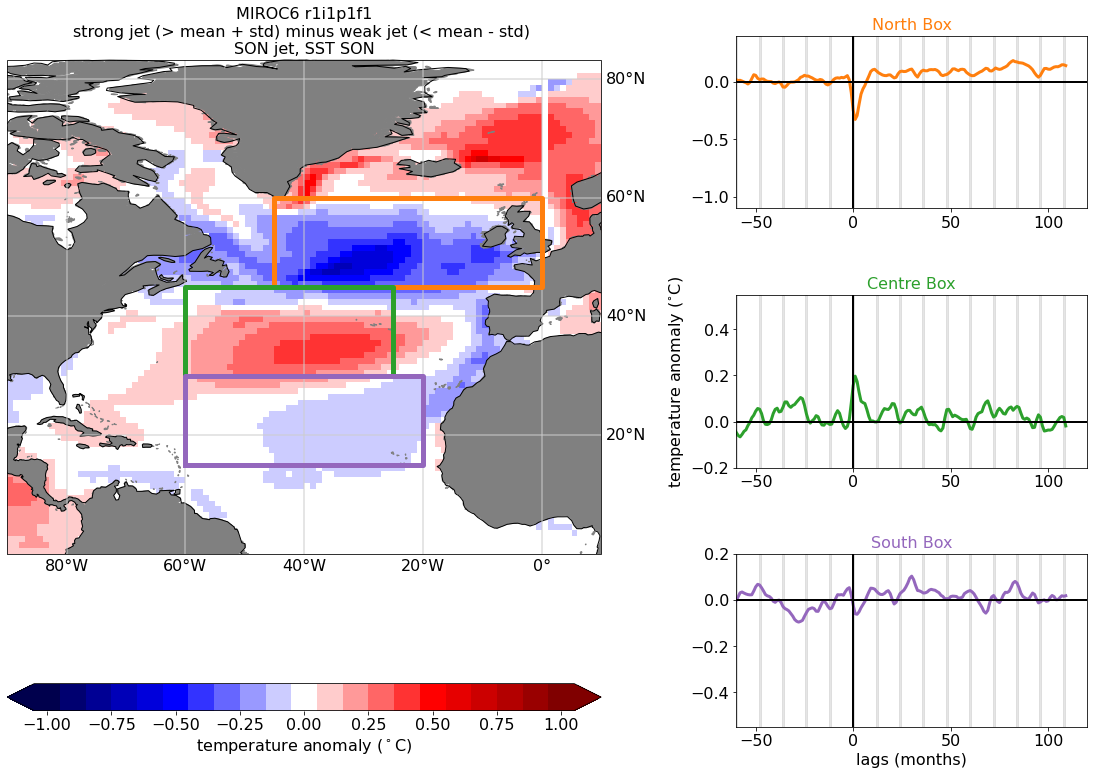

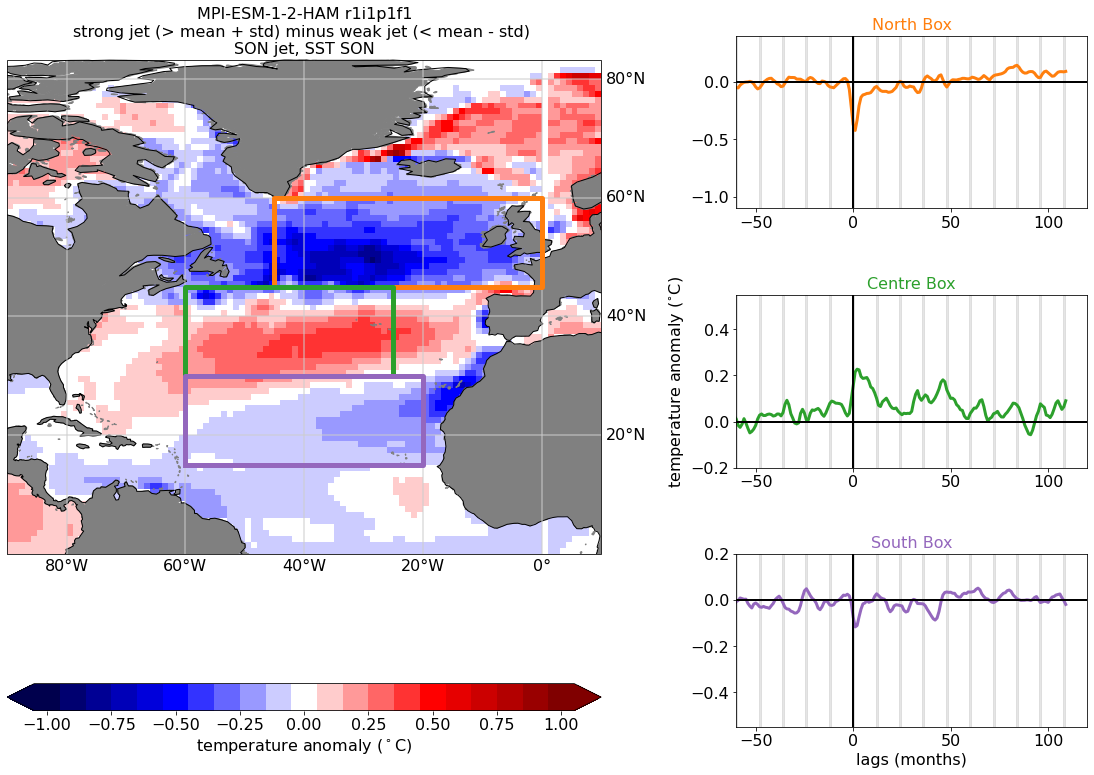

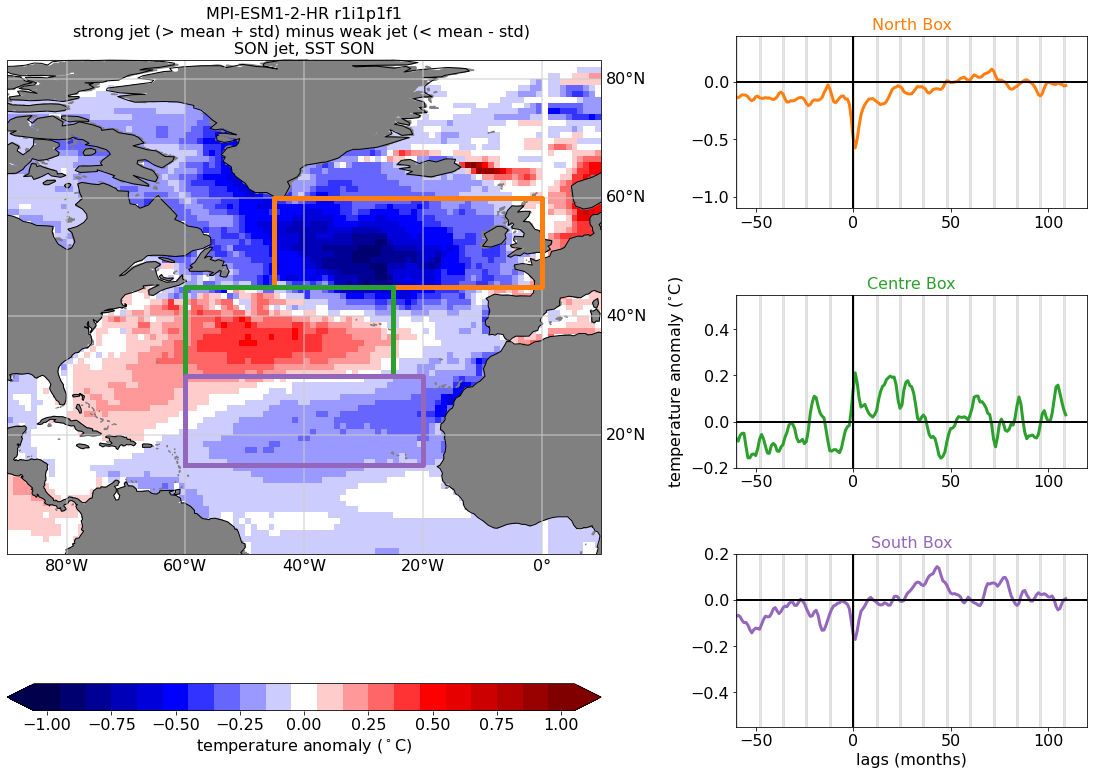

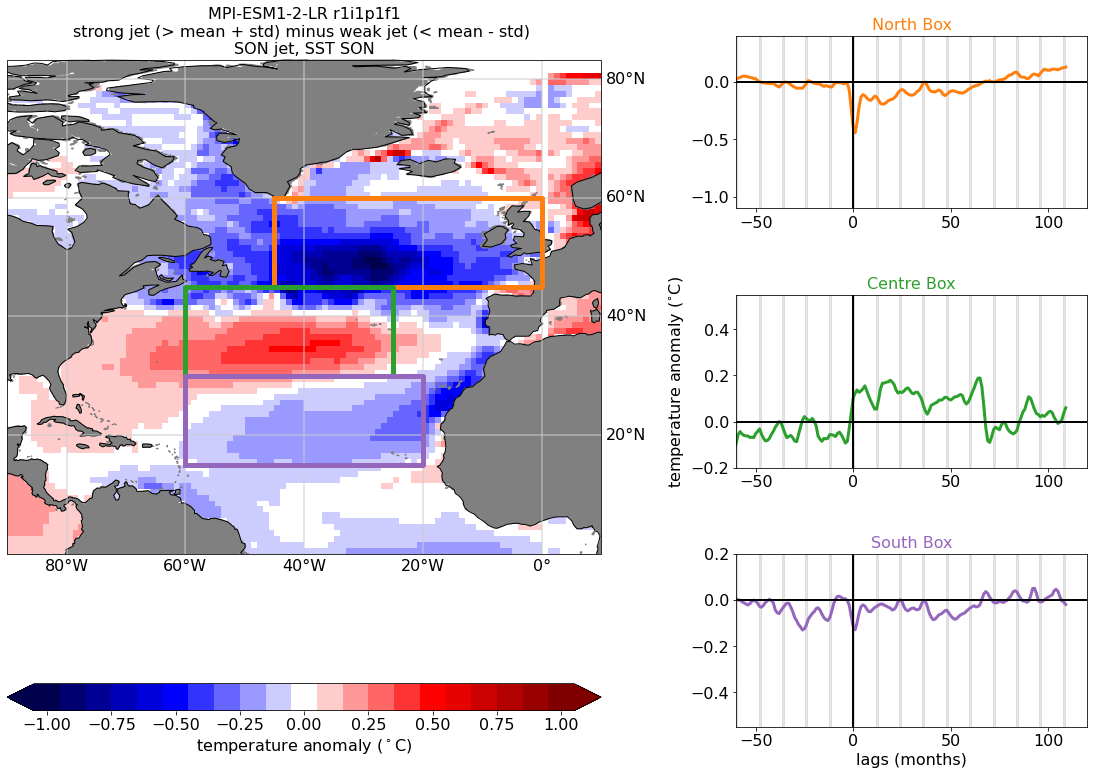

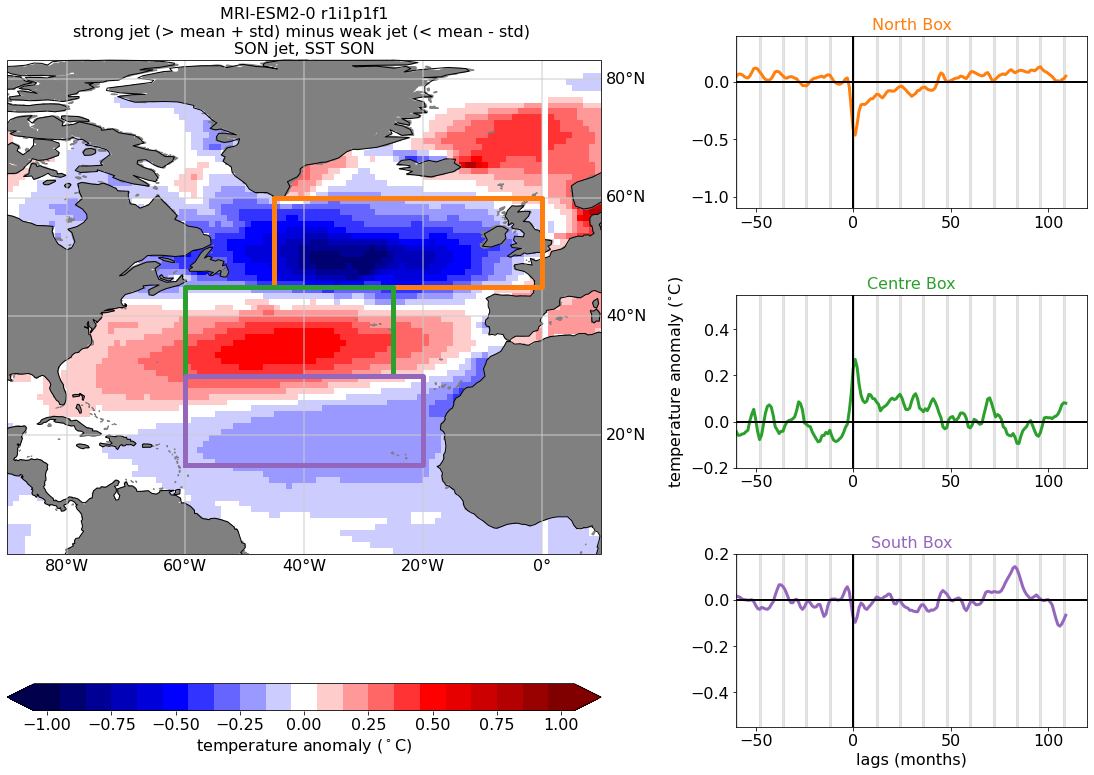

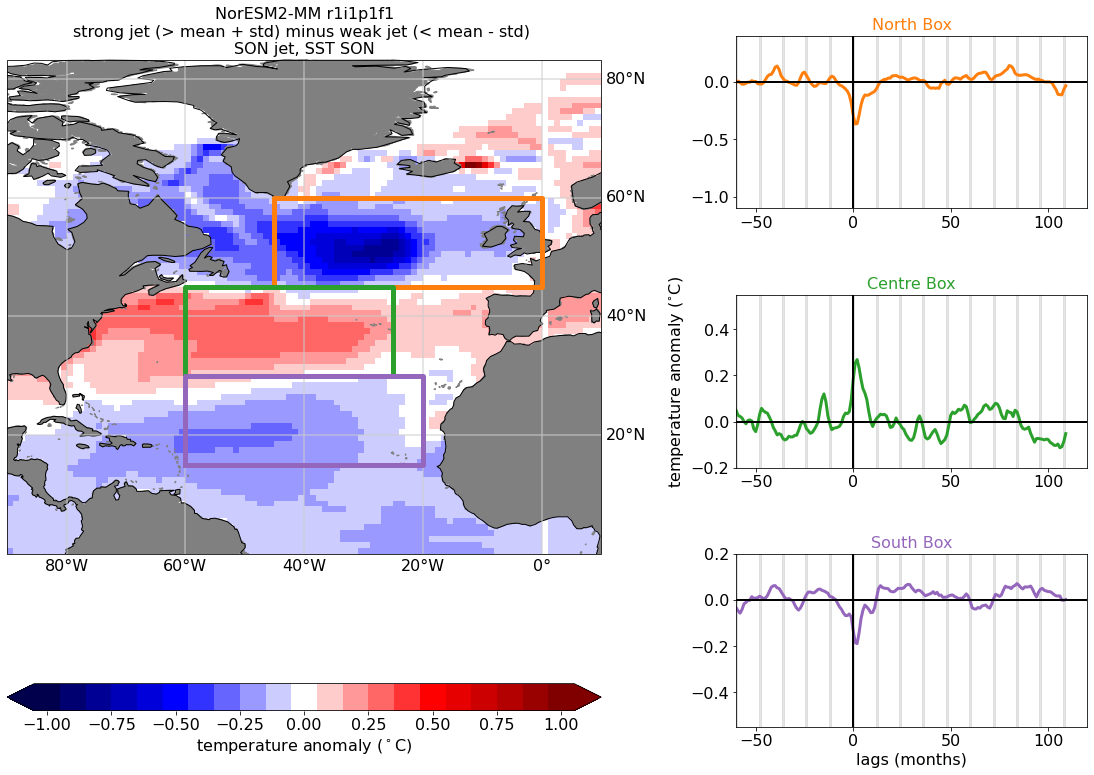

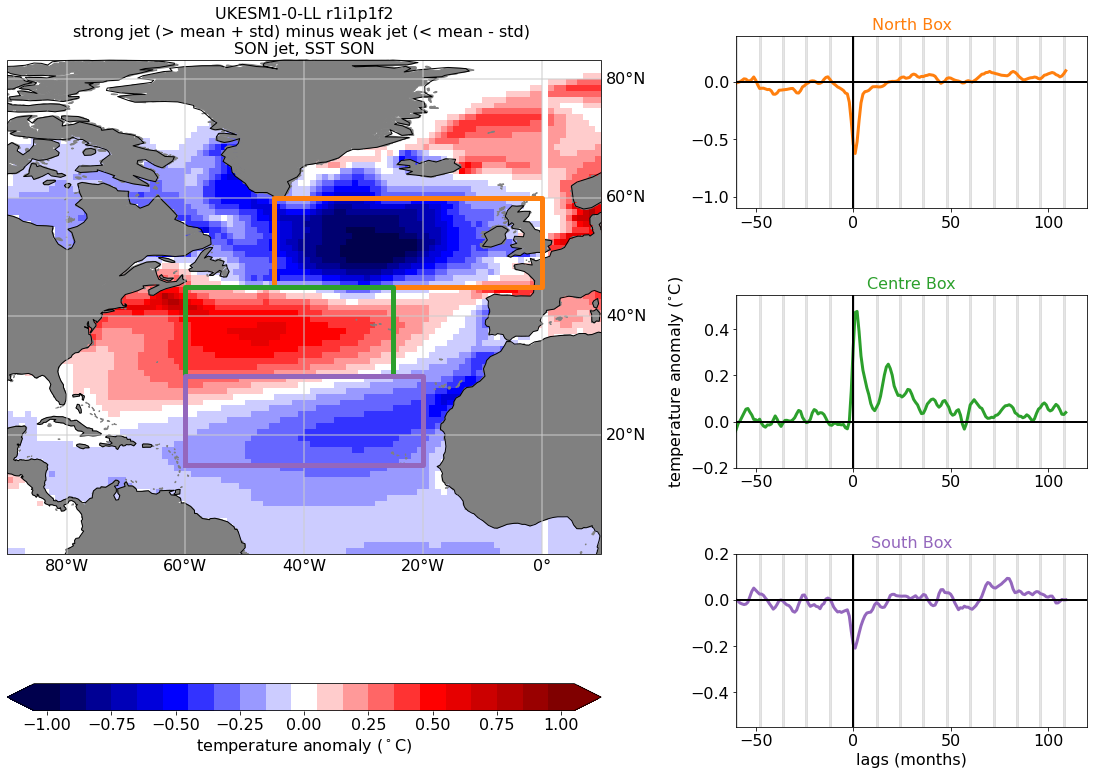

In [8]:
# Plot data (per Model):
mm = 0

fsize = 16

for mm in range(0,nm):
    fig   = plt.figure(figsize=(15,12))

    ax    = plt.axes([0,0,0.55,1],projection=ccrs.PlateCarree())
    ax.set_extent([-90,10,0,80])
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face', facecolor='0.5'))
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     lw=2,color='0.8',alpha=0.5)
    gl.xlabels_top  = False
    gl.ylabels_left = False
    gl.xlabel_style = {'size': fsize}
    gl.ylabel_style = {'size': fsize}

    plot_data = data_max1[mm,:,:] - data_min1[mm,:,:]
    plt.pcolormesh(lon,lat,plot_data,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cmap)
    cb = plt.colorbar(extend='both',orientation='horizontal')
    cb.ax.tick_params(labelsize=fsize)
    cb.set_label('temperature anomaly ($^\circ$C)',size=fsize)

    plt.plot([iminN,iminN,imaxN,imaxN,iminN],[jminN,jmaxN,jmaxN,jminN,jminN],color=colN,lw=5)
    plt.plot([iminM,iminM,imaxM,imaxM,iminM],[jminM,jmaxM,jmaxM,jminM,jminM],color=colM,lw=5)
    plt.plot([iminS,iminS,imaxS,imaxS,iminS],[jminS,jmaxS,jmaxS,jminS,jminS],color=colS,lw=5)

    plt.title((models[mm].split('_')[0] + ' '  + models[mm].split('_')[1] + '\n' + lmax1 + ' minus ' +
               lmin1 + ' \n' + season_ts + ' jet, SST ' + season_field),fontsize=fsize)

    ax    = plt.axes([0.675,0.7,0.325,0.2])
    plt.plot(lags_f,dataN_max1_f[mm,:]-dataN_min1_f[mm,:],lw=3,color=colN)
    for aa in range(-60,120,12):
        ax.axvspan(aa-0.5,aa+0.5, alpha=0.5, color='0.8')
    plt.axhline(y=0,color='k',lw=2)
    plt.axvline(x=0,color='k',lw=2)
    plt.xlim([-60,120])
    ax.tick_params(labelsize=fsize)
    plt.title('North Box',fontsize=fsize,color=colN)
    plt.ylim([-1.1,0.4])

    ax    = plt.axes([0.675,0.4,0.325,0.2])
    plt.plot(lags_f,dataM_max1_f[mm,:]-dataM_min1_f[mm,:],lw=3,color=colM)
    for aa in range(-60,120,12):
        ax.axvspan(aa-0.5,aa+0.5, alpha=0.5, color='0.8')
    plt.axhline(y=0,color='k',lw=2)
    plt.axvline(x=0,color='k',lw=2)
    plt.xlim([-60,120])
    ax.tick_params(labelsize=fsize)
    plt.title('Centre Box',fontsize=fsize,color=colM)
    plt.ylabel('temperature anomaly ($^{\circ}$C)',fontsize=fsize)
    plt.ylim([-0.2,0.55])

    ax    = plt.axes([0.675,0.1,0.325,0.2])
    plt.plot(lags_f,dataS_max1_f[mm,:]-dataS_min1_f[mm,:],lw=3,color=colS)
    for aa in range(-60,120,12):
        ax.axvspan(aa-0.5,aa+0.5, alpha=0.5, color='0.8')
    plt.axhline(y=0,color='k',lw=2)
    plt.axvline(x=0,color='k',lw=2)
    plt.xlim([-60,120])
    ax.tick_params(labelsize=fsize)
    plt.title('South Box',fontsize=fsize,color=colS)
    plt.xlabel('lags (months)',fontsize=fsize)
    plt.ylim([-0.55,0.2])

    figfile = (figdir + '/sst_box_' + models[mm] + '_' + var_ts  + '_' + season_ts + '_tos.png')

    fig.savefig(figfile,dpi=100,bbox_inches='tight', pad_inches=0.1)

/home/users/jmecking001/miniconda3/envs/working/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/jmecking001/miniconda3/envs/working/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/users/jmecking001/miniconda3/envs/working/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matp

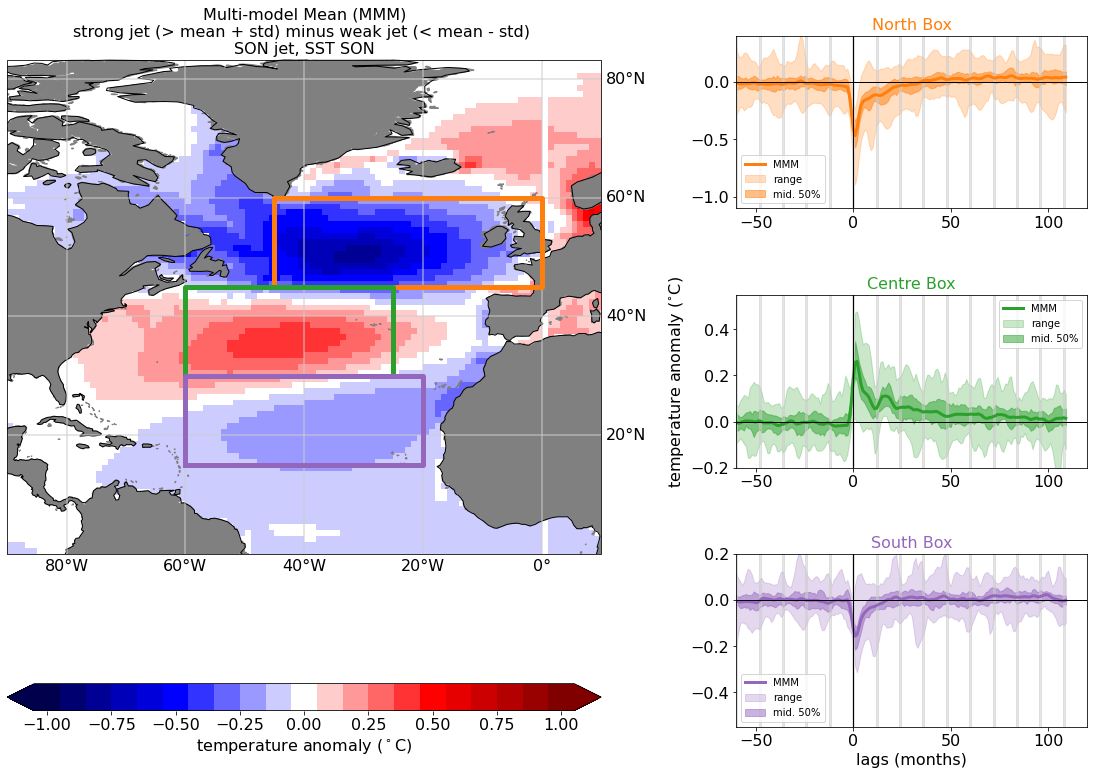

In [9]:
# Plot data (Multi-model Mean):

fig   = plt.figure(figsize=(15,12))
fsize = 16

ax    = plt.axes([0,0,0.55,1],projection=ccrs.PlateCarree())
ax.set_extent([-90,10,0,80])
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face', facecolor='0.5'))
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 lw=2,color='0.8',alpha=0.5)
gl.xlabels_top  = False
gl.ylabels_left = False
gl.xlabel_style = {'size': fsize}
gl.ylabel_style = {'size': fsize}

plot_data = max1_MMM - min1_MMM
plt.pcolormesh(lon,lat,plot_data,transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cmap)
cb = plt.colorbar(extend='both',orientation='horizontal')
cb.ax.tick_params(labelsize=fsize)
cb.set_label('temperature anomaly ($^\circ$C)',size=fsize)

plt.plot([iminN,iminN,imaxN,imaxN,iminN],[jminN,jmaxN,jmaxN,jminN,jminN],color=colN,lw=5)
plt.plot([iminM,iminM,imaxM,imaxM,iminM],[jminM,jmaxM,jmaxM,jminM,jminM],color=colM,lw=5)
plt.plot([iminS,iminS,imaxS,imaxS,iminS],[jminS,jmaxS,jmaxS,jminS,jminS],color=colS,lw=5)

plt.title(('Multi-model Mean (MMM)' + '\n' + lmax1 + ' minus ' +
           lmin1 + ' \n' + season_ts + ' jet, SST ' + season_field),fontsize=fsize)

ax    = plt.axes([0.675,0.7,0.325,0.2])
plt.plot(lags_f,np.mean(dataN_max1_f-dataN_min1_f,axis=0),lw=3,color=colN,label='MMM')
plt.fill_between(lags_f,np.min(dataN_max1_f-dataN_min1_f,axis=0),
                 np.max(dataN_max1_f-dataN_min1_f,axis=0),color=colN,alpha=0.25,label='range')
plt.fill_between(lags_f,np.quantile(dataN_max1_f-dataN_min1_f,0.25,axis=0),
                 np.quantile(dataN_max1_f-dataN_min1_f,0.75,axis=0),color=colN,alpha=0.5,label='mid. 50%')
for aa in range(-60,120,12):
    ax.axvspan(aa-0.5,aa+0.5, alpha=0.5, color='0.8')
plt.axhline(y=0,color='k',lw=1)
plt.axvline(x=0,color='k',lw=1)
plt.xlim([-60,120])
ax.tick_params(labelsize=fsize)
plt.title('North Box',fontsize=fsize,color=colN)
plt.legend()
plt.ylim([-1.1,0.4])

ax    = plt.axes([0.675,0.4,0.325,0.2])
plt.plot(lags_f,np.mean(dataM_max1_f-dataM_min1_f,axis=0),lw=3,color=colM,label='MMM')
plt.fill_between(lags_f,np.min(dataM_max1_f-dataM_min1_f,axis=0),
                 np.max(dataM_max1_f-dataM_min1_f,axis=0),color=colM,alpha=0.25,label='range')
plt.fill_between(lags_f,np.quantile(dataM_max1_f-dataM_min1_f,0.25,axis=0),
                 np.quantile(dataM_max1_f-dataM_min1_f,0.75,axis=0),color=colM,alpha=0.5,label='mid. 50%')

for aa in range(-60,120,12):
    ax.axvspan(aa-0.5,aa+0.5, alpha=0.5, color='0.8')
plt.axhline(y=0,color='k',lw=1)
plt.axvline(x=0,color='k',lw=1)
plt.xlim([-60,120])
ax.tick_params(labelsize=fsize)
plt.title('Centre Box',fontsize=fsize,color=colM)
plt.ylabel('temperature anomaly ($^{\circ}$C)',fontsize=fsize)
plt.legend()
plt.ylim([-0.2,0.55])

ax    = plt.axes([0.675,0.1,0.325,0.2])
plt.plot(lags_f,np.mean(dataS_max1_f-dataS_min1_f,axis=0),lw=3,color=colS,label='MMM')
plt.fill_between(lags_f,np.min(dataS_max1_f-dataS_min1_f,axis=0),
                 np.max(dataS_max1_f-dataS_min1_f,axis=0),color=colS,alpha=0.25,label='range')
plt.fill_between(lags_f,np.quantile(dataS_max1_f-dataS_min1_f,0.25,axis=0),
                 np.quantile(dataS_max1_f-dataS_min1_f,0.75,axis=0),color=colS,alpha=0.5,label='mid. 50%')

for aa in range(-60,120,12):
    ax.axvspan(aa-0.5,aa+0.5, alpha=0.5, color='0.8')
plt.axhline(y=0,color='k',lw=1)
plt.axvline(x=0,color='k',lw=1)
plt.xlim([-60,120])
ax.tick_params(labelsize=fsize)
plt.title('South Box',fontsize=fsize,color=colS)
plt.xlabel('lags (months)',fontsize=fsize)
plt.legend()
plt.ylim([-0.55,0.2])

figfile = (figdir + '/sst_box_MMM_' + var_ts  + '_' + season_ts + '_tos.png')

fig.savefig(figfile,dpi=100,bbox_inches='tight', pad_inches=0.1)

###### 